# Fundamentals-of-Neural-Networks
This project is part of the 5LSH0 - Computer Vision AI and 3D Data Analysis course at TU Eindhoven. It focuses on the fundamentals of neural networks, with an emphasis on implementing a Multi-Layer Perceptron (MLP) to classify digits from the MNIST dataset. You will work with fully-connected layers, activation functions (ReLU and Sigmoid), and mini-batch SGD with cross-entropy loss. The project also involves analyzing the model’s performance, calculating trainable parameters, and experimenting with different loss functions such as Cross-Entropy, Dice, and Focal Loss to enhance accuracy.

### Variables explanation
- **W1**: Weights for the first layer (input to hidden layer)
- **b1**: Bias for the first layer
- **W2**: Weights for the second layer (hidden to output layer)
- **b2**: Bias for the second layer
- **A1**: Activation of the first layer (output after applying activation function to Z1)
- **A2**: Output of the network (after applying softmax activation function to Z2)
- **Z1**: Linear transformation for the first layer (W1.dot(values) + b1)
- **Z2**: Linear transformation for the second layer (W2.dot(A1) + b2)
- **m**: Number of training examples (samples in the training set)
- **n**: Number of features (including labels)
- **values**: Input features (e.g., pixel values for MNIST images)
- **labels**: Ground truth labels (e.g., corresponding digit labels for MNIST images)
- **dW1**: Gradient of the weights for the first layer
- **db1**: Gradient of the bias for the first layer
- **dW2**: Gradient of the weights for the second layer
- **db2**: Gradient of the bias for the second layer
- **alpha**: Learning rate (step size for weight updates)

mini batch gradient descen iterations 500,  alpha 0.1,  sigmoid - traininig 10min, accuracy 0.65, loss 1.04
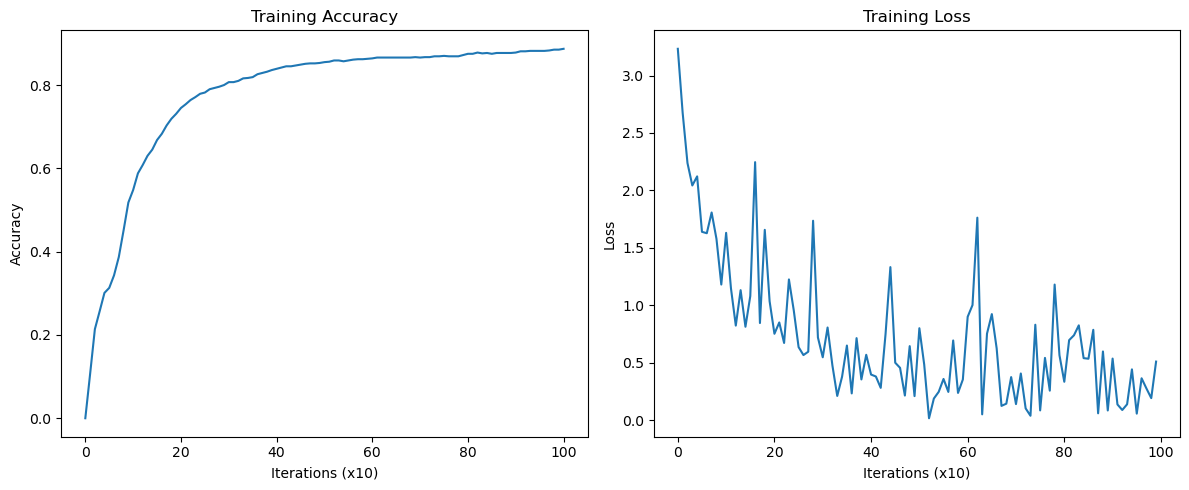

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [76]:
DEBUG = True # Used to display additional information during program execution
TEST_SIZE = 1000
VALIDATION_SIZE = 1000
ALPHA = 0.1
ITERATIONS = 1000
BATCHSIZE = 64
TRAININIG_UPDATES = 10 #number of iterations after which trainiing update is printed

In [77]:
def show_image(values, index):
    """
    Display image selected by index from given values matrix
    """
    image = values[:, index, None]
    image = image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(image)
    plt.show()

In [78]:
#Load dataset from a file
data = pd.read_csv('Datasets/MNIST_CSV/mnist.csv', header=None)
if DEBUG:
    print(data.head())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


n = 785
m = 70000
labels_train.shape = (69000,)
values_train.shape = (784, 69000)
labels_test.shape = (1000,)
values_test.shape = (784, 1000)


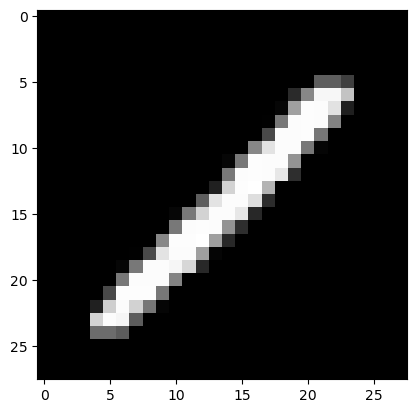

In [79]:
# Divide dataset to test, validation and train sets

data = np.array(data)
m, n = data.shape # n is amount of features including labels 

np.random.shuffle(data)

data_test = data[0:TEST_SIZE].T
labels_test = data_test[0]
values_test = data_test[1:n] / 255

data_validation = data[TEST_SIZE:(TEST_SIZE+ VALIDATION_SIZE)].T
labels_validation = data_validation[0]
values_validation = data_validation[1:n] / 255

data_train = data[TEST_SIZE:m].T
labels_train = data_train[0]
values_train = data_train[1:n] / 255

if DEBUG:
    print("n =",n)
    print("m =",m)
    print("labels_train.shape =",labels_train.shape)
    print("values_train.shape =",values_train.shape)
    print("labels_test.shape =",labels_test.shape)
    print("values_test.shape =",values_test.shape)
    show_image(values_train, 1)

In [80]:
def init_params():
    """Initialize NN weights and biases"""
    #
    W1 = np.random.rand(10,784) - 0.5
    b1 = np.random.rand(10,1) - 0.5

    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    """Calculate ReLu activation function"""
    return np.maximum(0, Z)

def sigmoid(Z):
    """Calculate Sigmoid activation function"""
    return 1 / (1 + np.exp(-Z))

def softmax(Z):
    """Calculate softmax of given vector Z"""
    Z -= np.max(Z, axis=0)
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def forward_propagation(W1, b1, W2, b2, values):
    """Pass through the NN input->output"""
    Z1 = W1.dot(values) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(labels, num_classes=10):
    """Perform one-hot encoding for a batch of labels"""
    one_hot_labels = np.zeros((num_classes, labels.size))
    one_hot_labels[labels, np.arange(labels.size)] = 1
    return one_hot_labels

def deriv_ReLU(Z):
    """Derivative of ReLU activation function"""
    return Z > 0

def deriv_sigmoid(Z):
    """Calculate derivative of sigmoid activation function"""
    return sigmoid(Z) * (1 - sigmoid(Z))
    
def back_propagation(Z1, A1, Z2, A2, W2, values, labels):
    """Perform back propagation through NN output->input"""

    # Calculate output error compared to one hot labels
    one_hot_labels = one_hot(labels)
    dZ2 = A2 - one_hot_labels

    # Calculate gradients for weights in second layer
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, 1)

    # calculate first layers error by propagating error backwards
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)

    # Calculate gradients for weights in first layer
    dW1 = 1 / m * dZ1.dot(values.T)
    db1 = 1 / m * np.sum(dZ1, 1)

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """Update NN weights and biases"""
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * np.reshape(db1, (10,1)) # reshape from single value to vector
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * np.reshape(db2, (10,1)) # reshape from single value to vector
    return W1, b1, W2, b2

In [81]:
def cross_entropy_loss(A2, one_hot_labels):
    """
    Calculate cross-entropy loss 
    A2: predicted probabilities from softmax (shape: [num_classes, batch_size])
    one_hot_labels: one-hot encoded true labels (shape: [num_classes, batch_size])
    """
    m = one_hot_labels.shape[1]
    log_likelihood = -np.log(np.sum(A2 * one_hot_labels, axis=0))  # Corrected here
    loss = np.sum(log_likelihood) / m
    return loss

In [82]:
def get_predictions(A2):
    """Use highest value from given vector for prediction"""
    return np.argmax(A2, 0)

def get_accuracy(predictions, labels):
    """Calculate accuracy based on given predictions and labels"""
    return np.sum(predictions == labels) / labels.size

def make_predictions(values, W1, b1, W2, b2):
    """Make prediction based on chosen values using given model parameters"""
    _, _, _, A2 = forward_propagation(W1,b1,W2,b2,values)
    predictions = get_predictions(A2)
    return predictions
    
def mini_batch_gradient_descent(values_train, labels_train, iterations, alpha, batch_size, values_validation, labels_validation):
    """Create a 3-layer NN and train it using mini-batch gradient descent"""
    W1, b1, W2, b2 = init_params()
    accuracy_history = [0]
    loss_history = []

    # Number of training examples
    m = values_train.shape[1]

    for i in range(iterations):
        # Shuffle training data
        permutation = np.random.permutation(m)
        values_train_shuffled = values_train[:, permutation]
        labels_train_shuffled = labels_train[permutation]

        # Mini-batch gradient descent
        for j in range(0, m, batch_size):
            # Get mini-batch data
            batch_values = values_train_shuffled[:, j:j+batch_size]
            batch_labels = labels_train_shuffled[j:j+batch_size]

            # Forward propagation
            Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, batch_values)

            # Back propagation
            dW1, db1, dW2, db2 = back_propagation(Z1, A1, Z2, A2, W2, batch_values, batch_labels)

            # Update parameters
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        # Training progress
        if i % TRAININIG_UPDATES == 0:
            print(f"Iteration: {i}")

            # Make predictions and test accuracy using validation set
            predictions = make_predictions(values_validation, W1, b1, W2, b2)
            accuracy = get_accuracy(predictions, labels_validation)

            # One-hot encode the mini-batch labels for loss calculation
            one_hot_labels_batch = one_hot(batch_labels)
            loss = cross_entropy_loss(A2, one_hot_labels_batch)

            print(f"Accuracy: {accuracy}")
            print(f"Loss: {loss}")

            # Store training progress
            accuracy_history.append(accuracy)
            loss_history.append(loss)

            # Plot the training progress
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

            ax[0].plot(accuracy_history)
            ax[0].set_title("Training Accuracy")
            ax[0].set_xlabel("Iterations (x10)")
            ax[0].set_ylabel("Accuracy")

            ax[1].plot(loss_history)
            ax[1].set_title("Training Loss")
            ax[1].set_xlabel("Iterations (x10)")
            ax[1].set_ylabel("Loss")

            plt.tight_layout()
            plt.show()

    return W1, b1, W2, b2


Iteration: 0
Accuracy: 0.106
Loss: 3.232516146224472


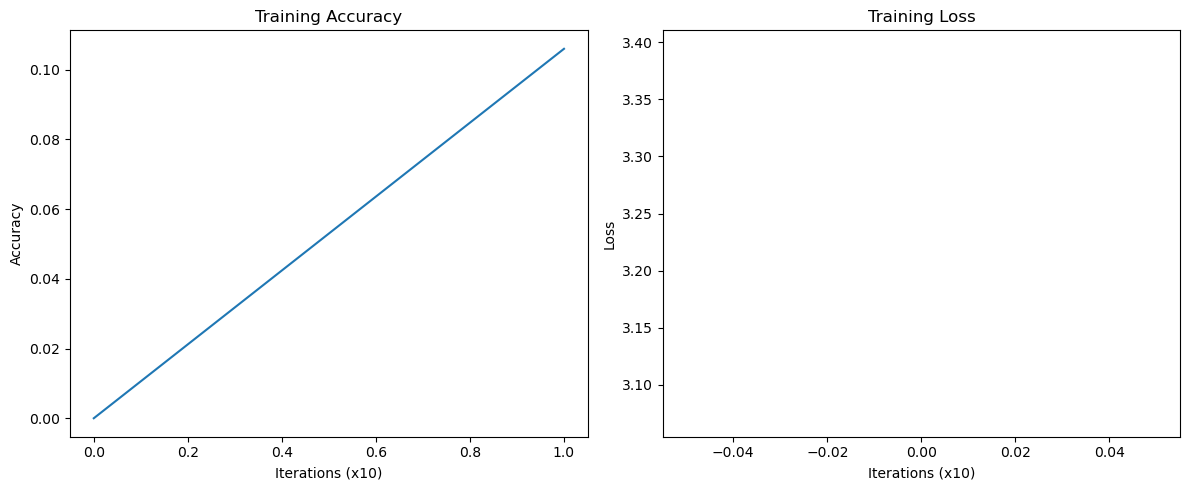

Iteration: 10
Accuracy: 0.214
Loss: 2.6760549765329933


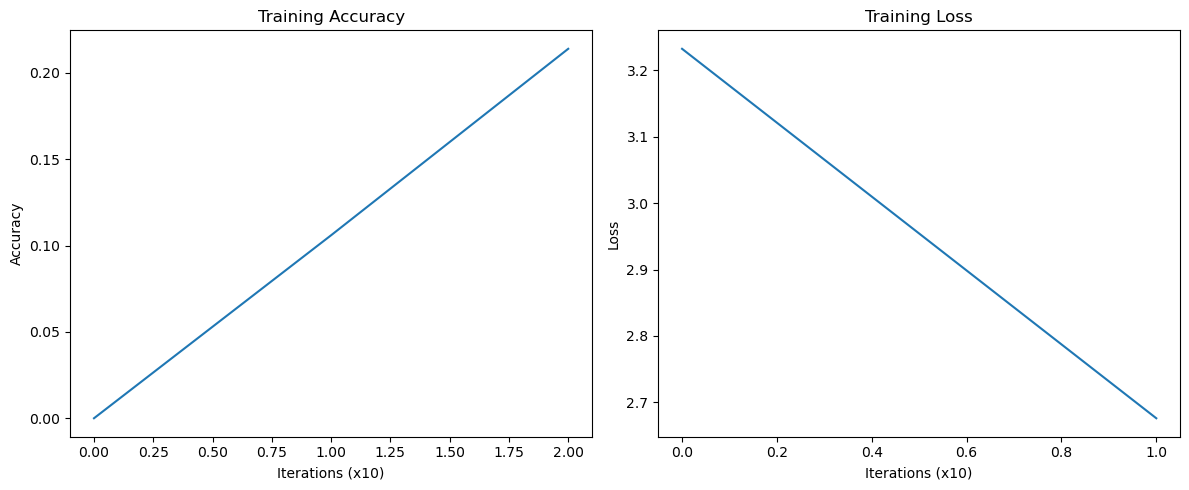

Iteration: 20
Accuracy: 0.257
Loss: 2.2379534218294053


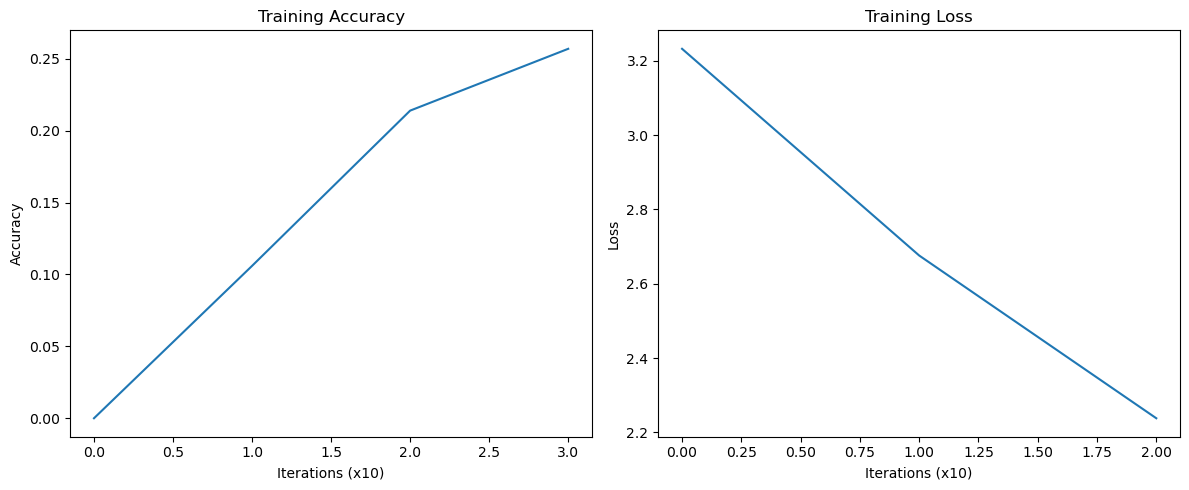

Iteration: 30
Accuracy: 0.301
Loss: 2.042633342983266


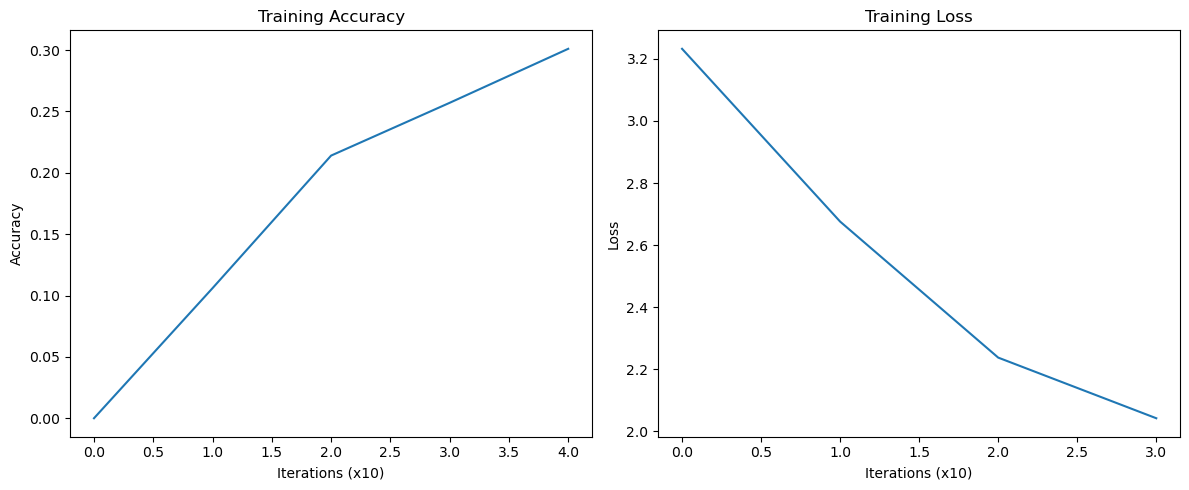

Iteration: 40
Accuracy: 0.313
Loss: 2.121811413757406


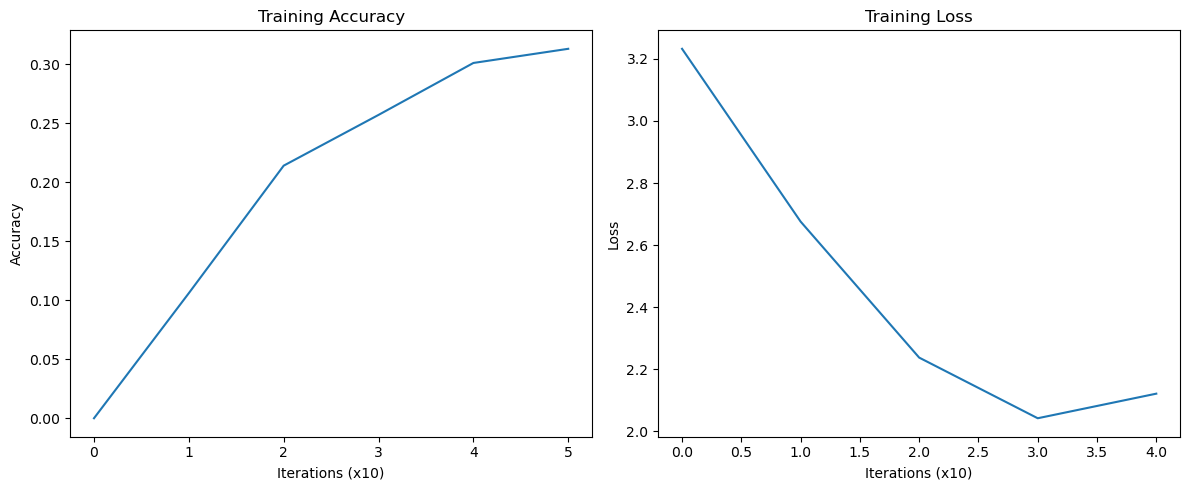

Iteration: 50
Accuracy: 0.343
Loss: 1.6390003445932162


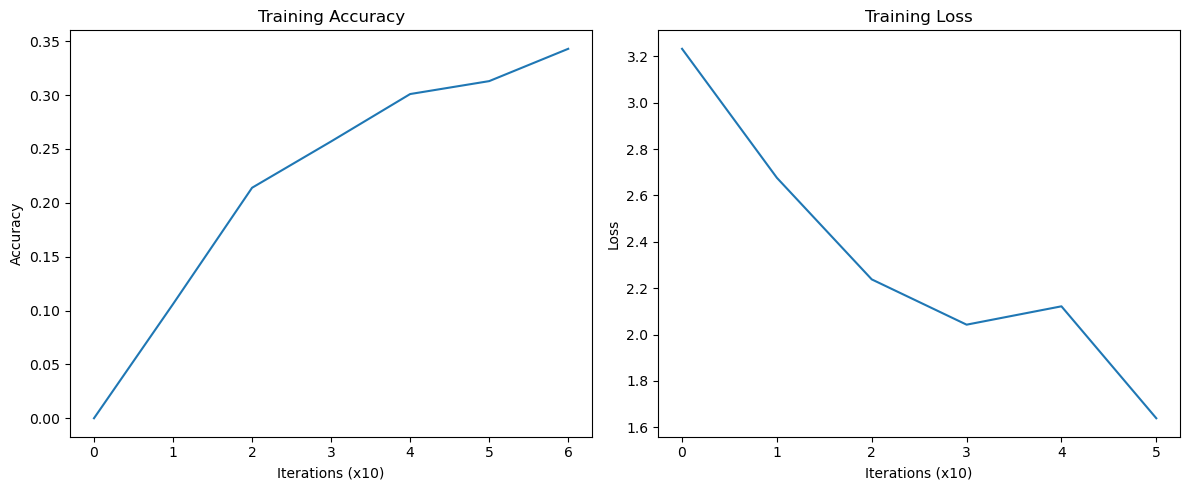

Iteration: 60
Accuracy: 0.387
Loss: 1.6268839480225203


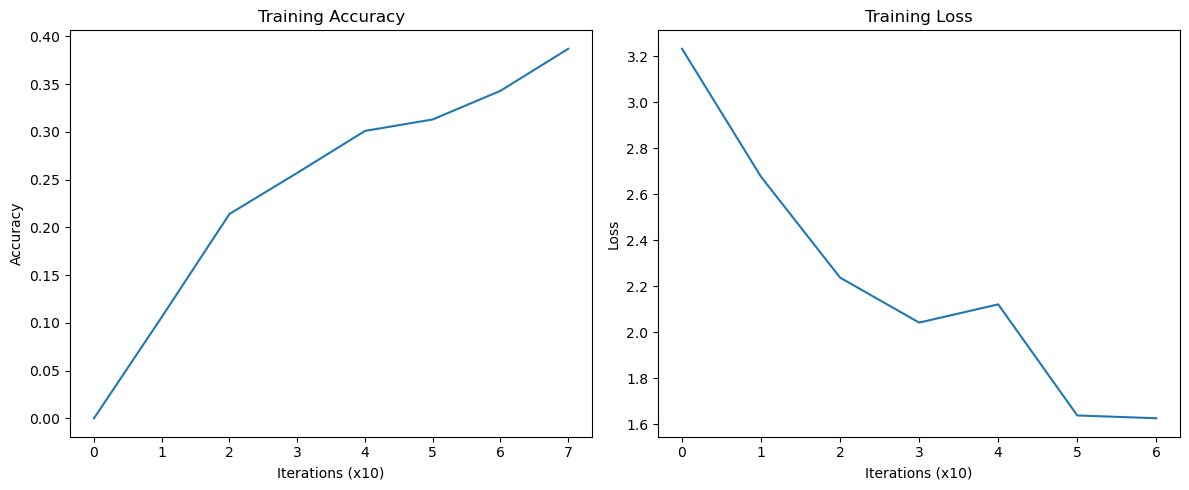

Iteration: 70
Accuracy: 0.451
Loss: 1.8073942801287712


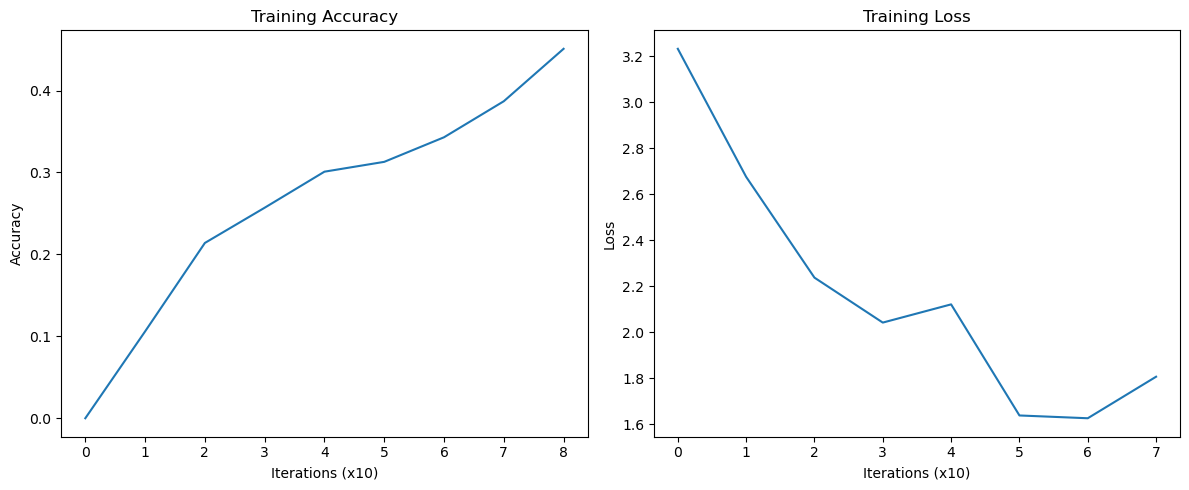

Iteration: 80
Accuracy: 0.518
Loss: 1.577545495328562


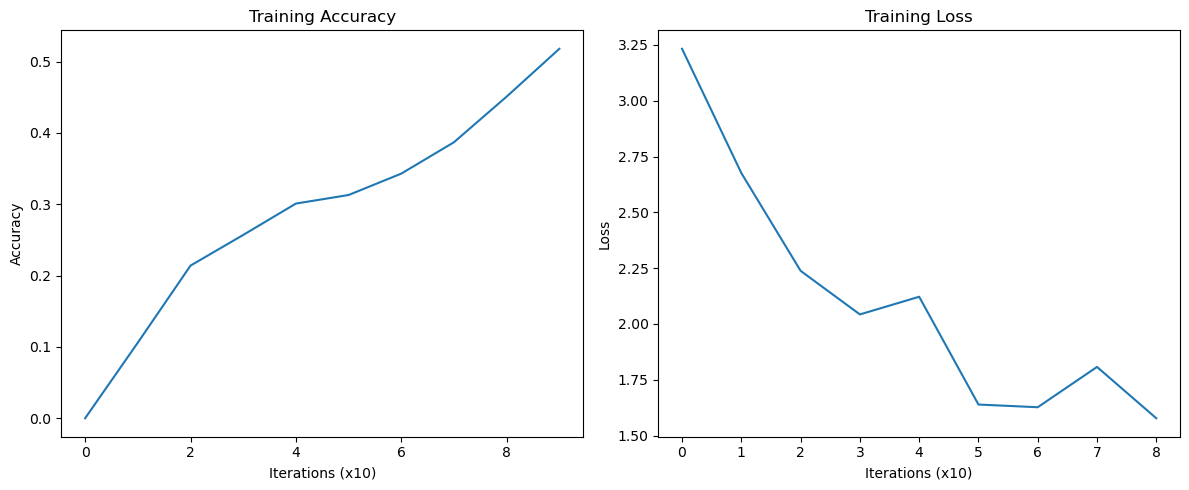

Iteration: 90
Accuracy: 0.548
Loss: 1.1800889572230553


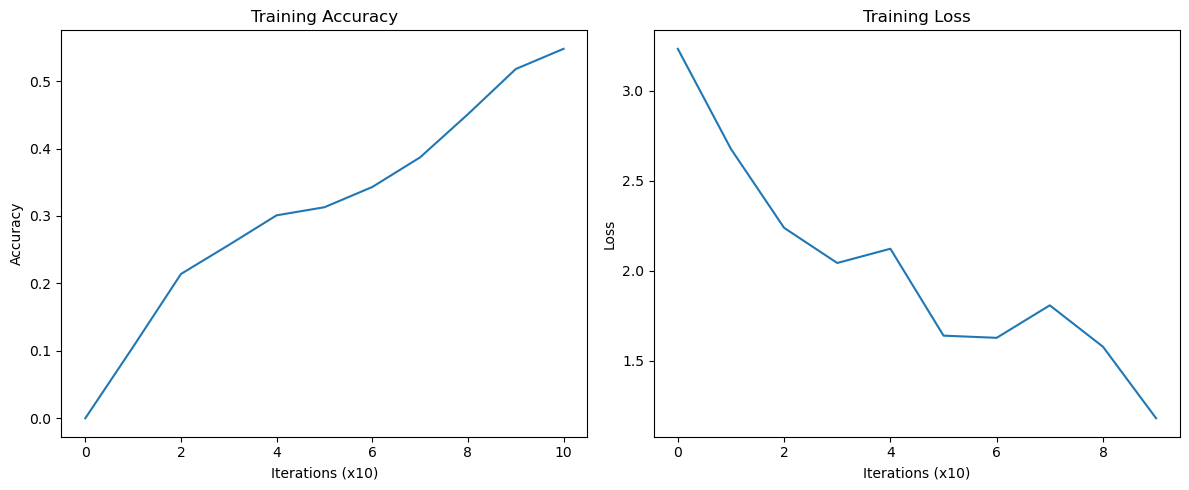

Iteration: 100
Accuracy: 0.588
Loss: 1.6301444955684878


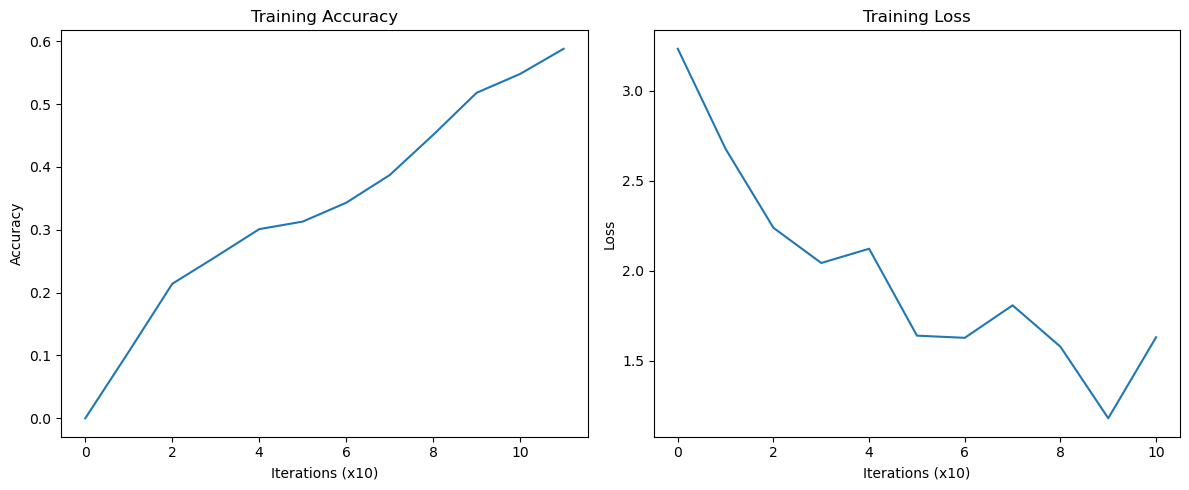

Iteration: 110
Accuracy: 0.608
Loss: 1.1474255620504952


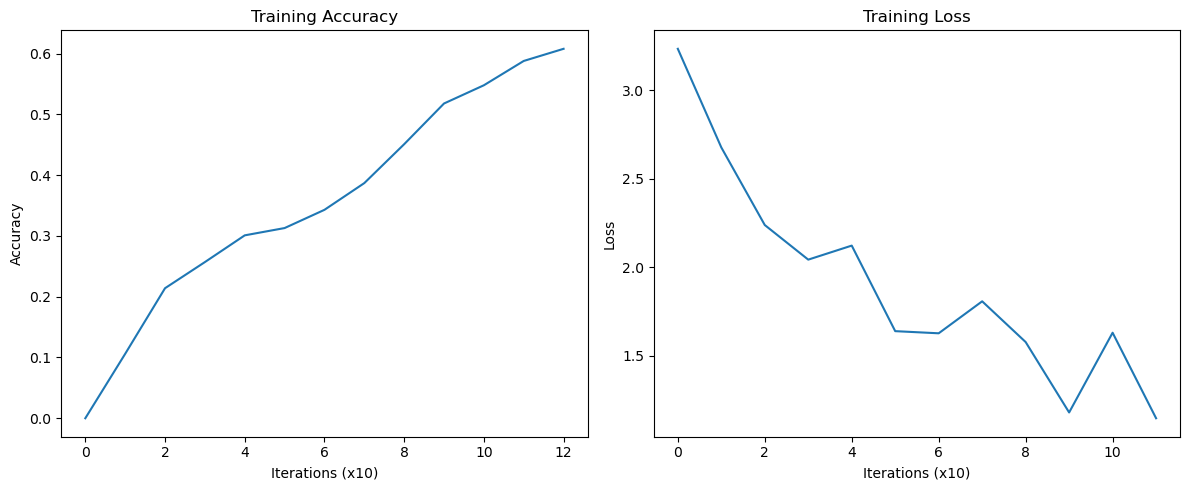

Iteration: 120
Accuracy: 0.63
Loss: 0.8226486999015712


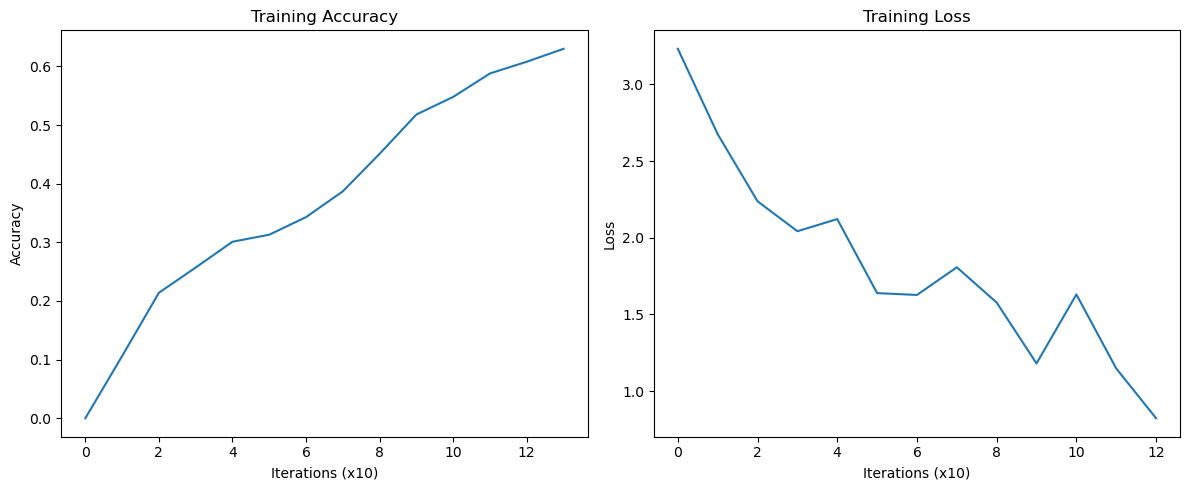

Iteration: 130
Accuracy: 0.645
Loss: 1.1310148332551262


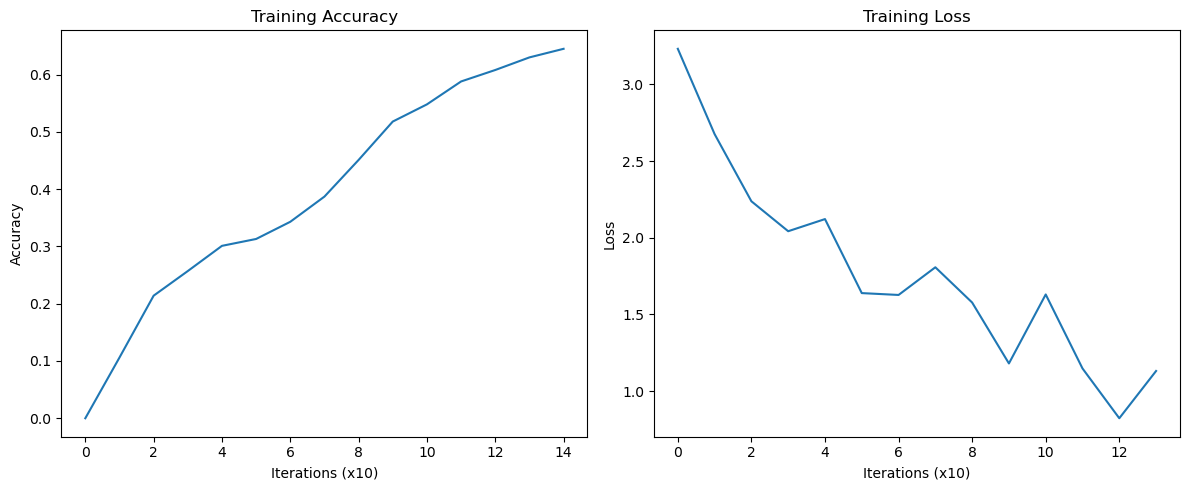

Iteration: 140
Accuracy: 0.668
Loss: 0.8124954357867701


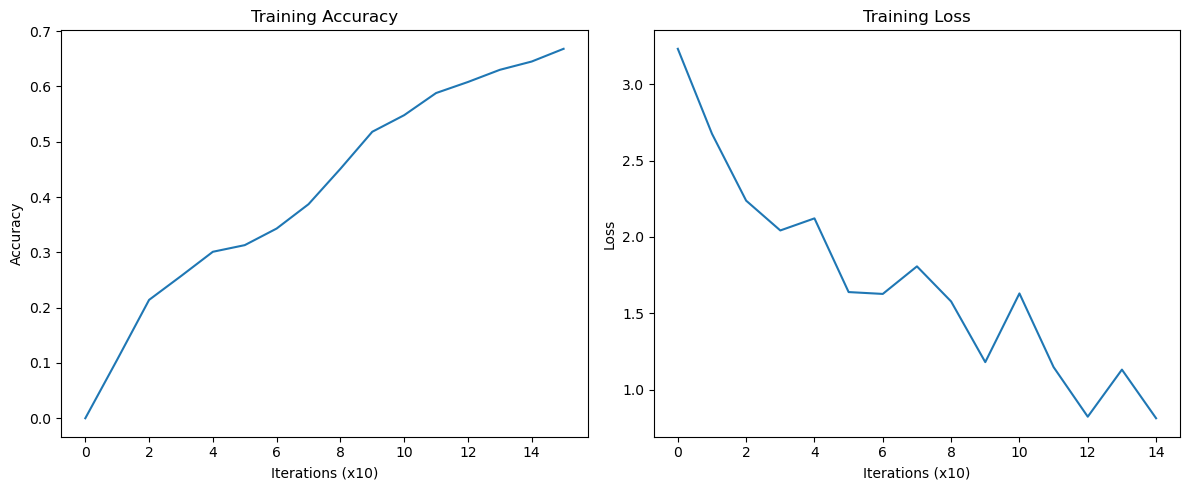

Iteration: 150
Accuracy: 0.683
Loss: 1.0793741412903357


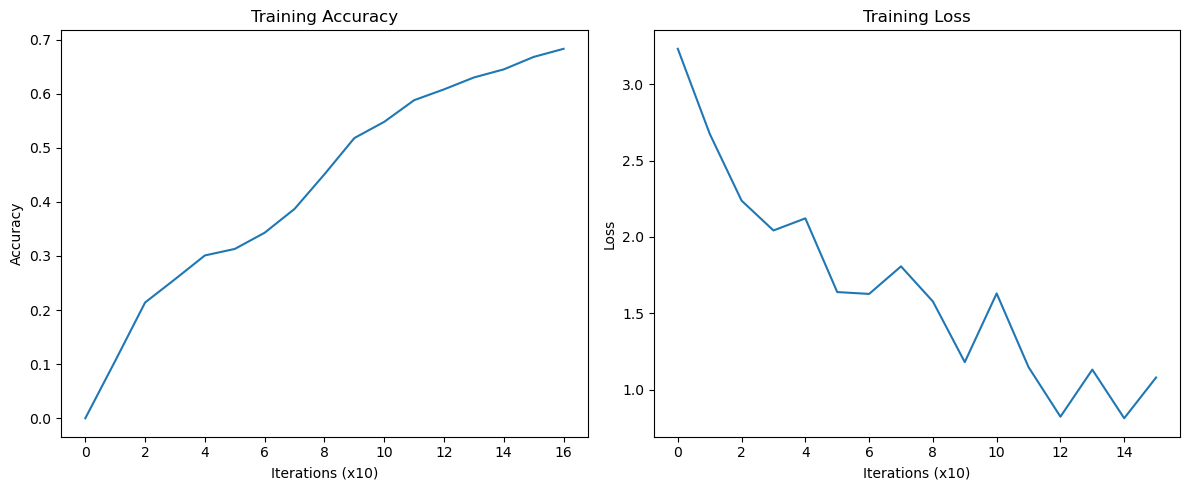

Iteration: 160
Accuracy: 0.703
Loss: 2.2457079468443966


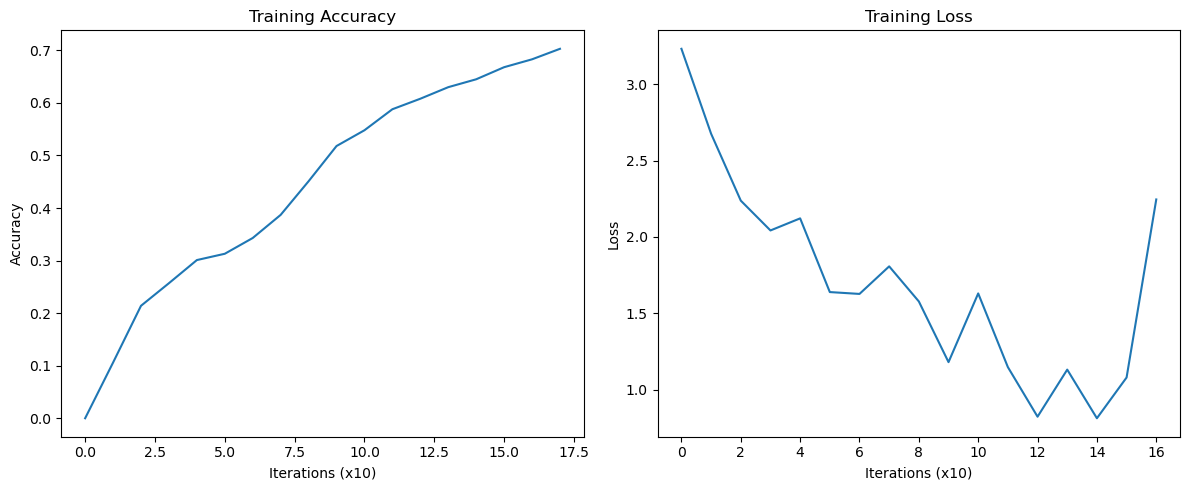

Iteration: 170
Accuracy: 0.719
Loss: 0.8448839663759206


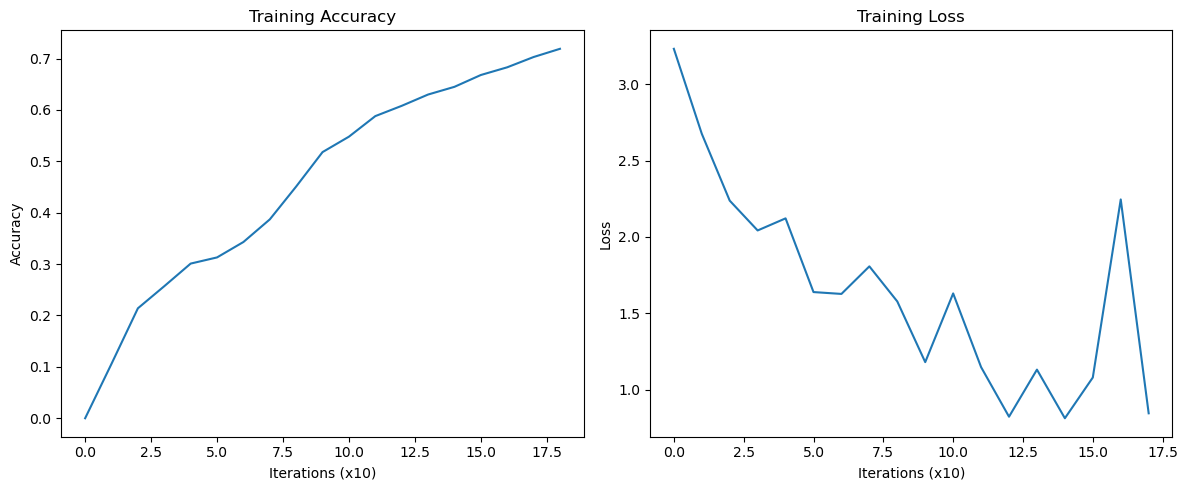

Iteration: 180
Accuracy: 0.731
Loss: 1.6563122311644352


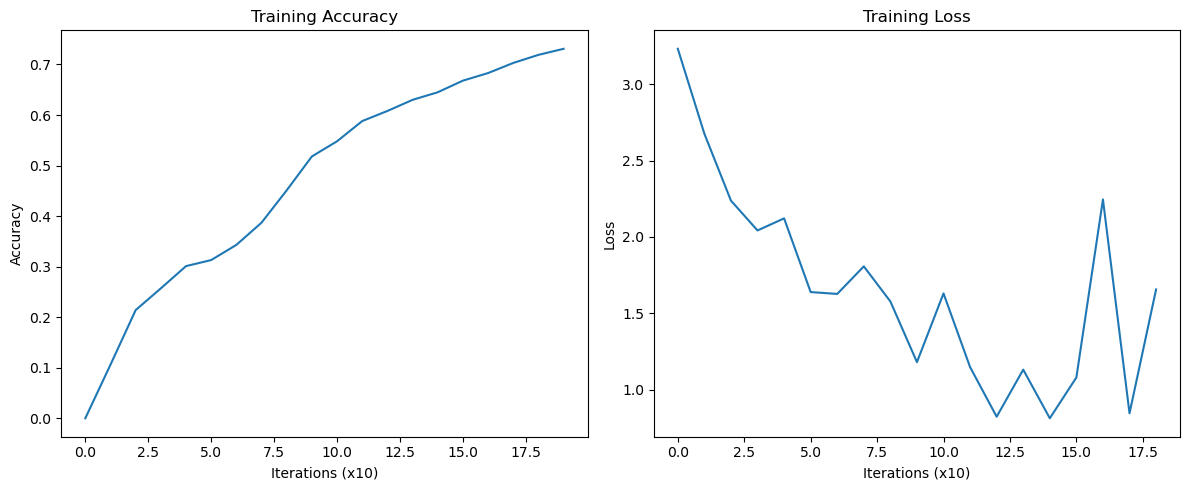

Iteration: 190
Accuracy: 0.745
Loss: 1.0343950443213523


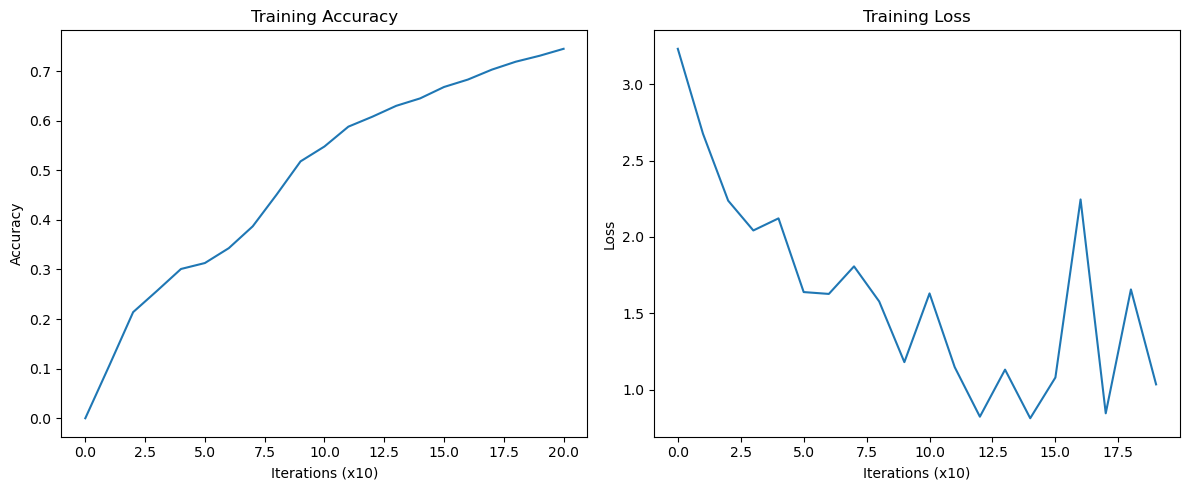

Iteration: 200
Accuracy: 0.754
Loss: 0.7513202565465289


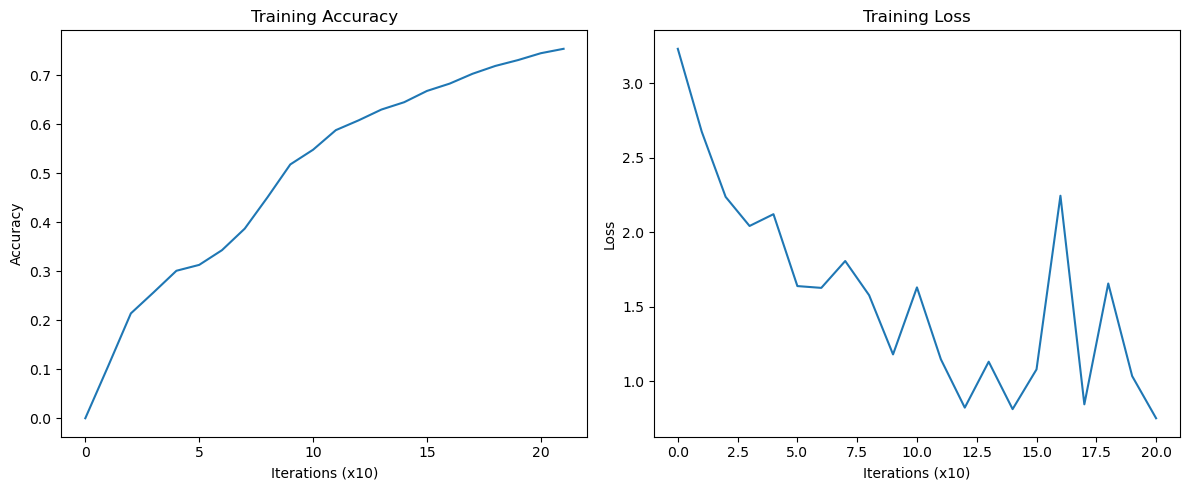

Iteration: 210
Accuracy: 0.764
Loss: 0.8497516365016085


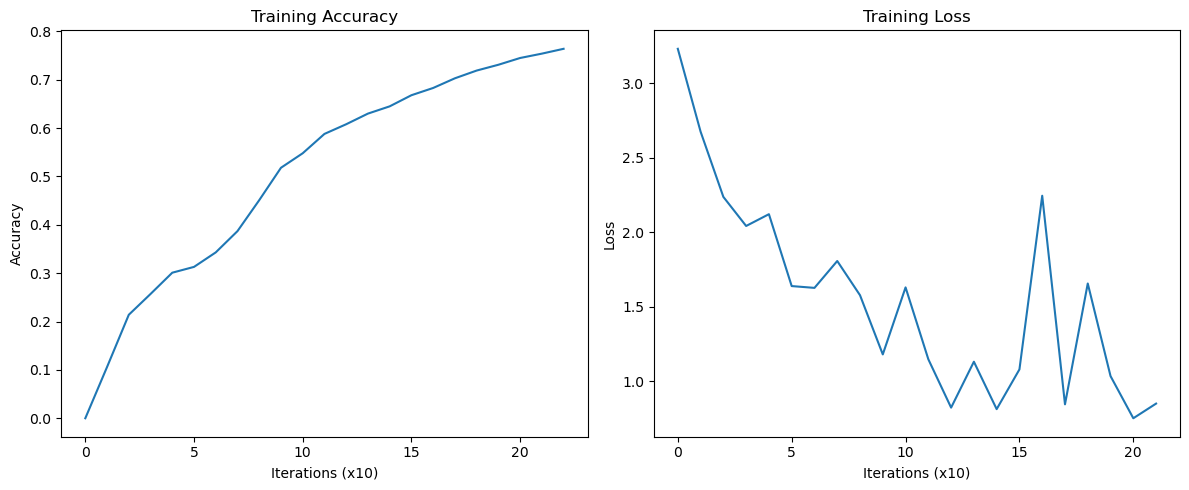

Iteration: 220
Accuracy: 0.771
Loss: 0.6714944585070268


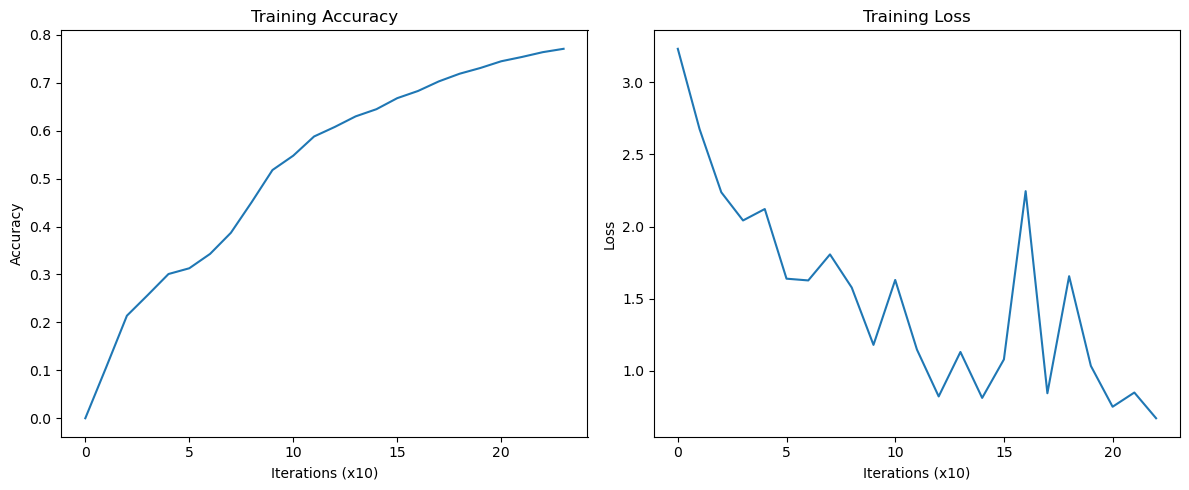

Iteration: 230
Accuracy: 0.779
Loss: 1.224430769426691


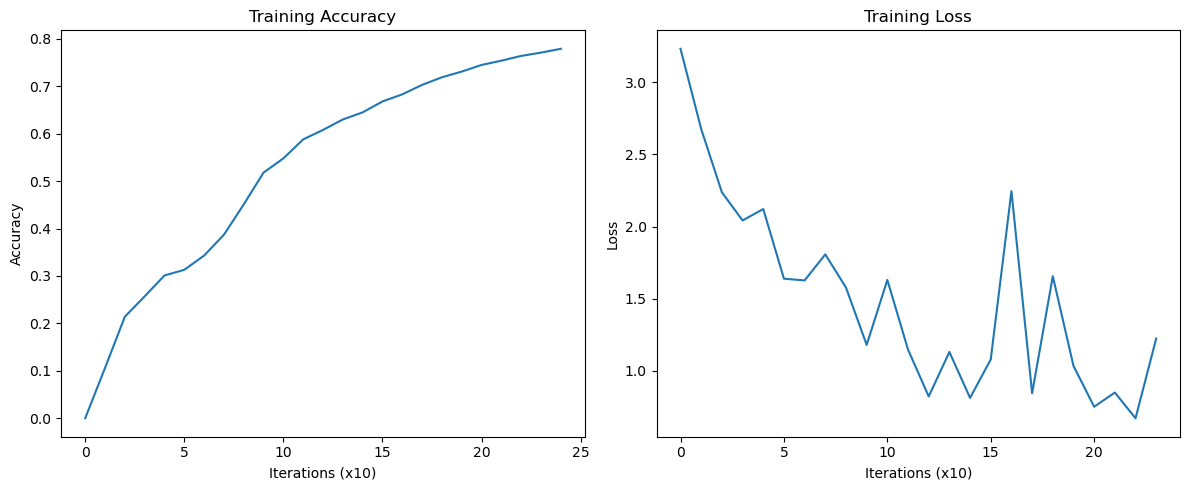

Iteration: 240
Accuracy: 0.782
Loss: 0.9552410425012928


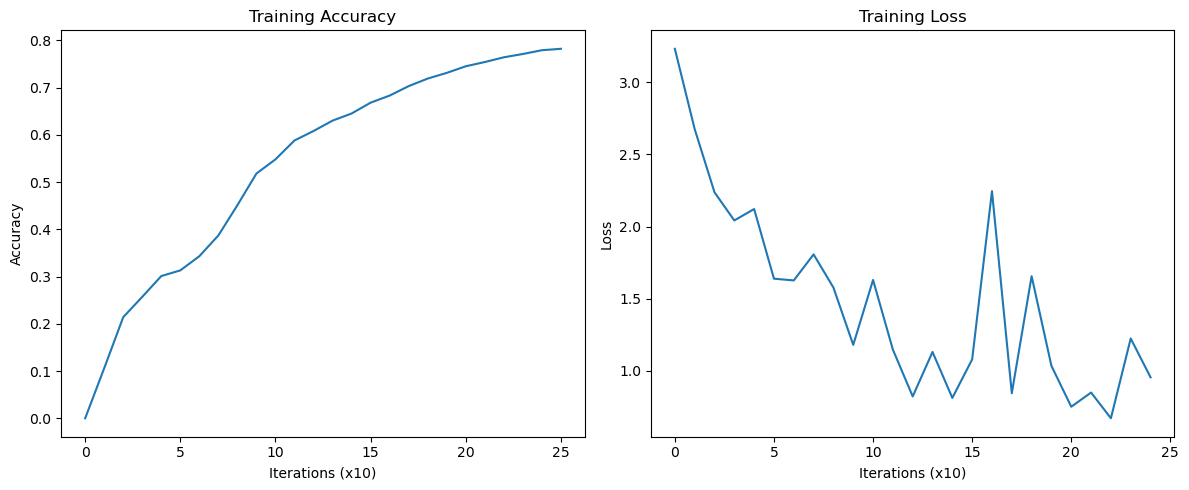

Iteration: 250
Accuracy: 0.79
Loss: 0.6352593585930033


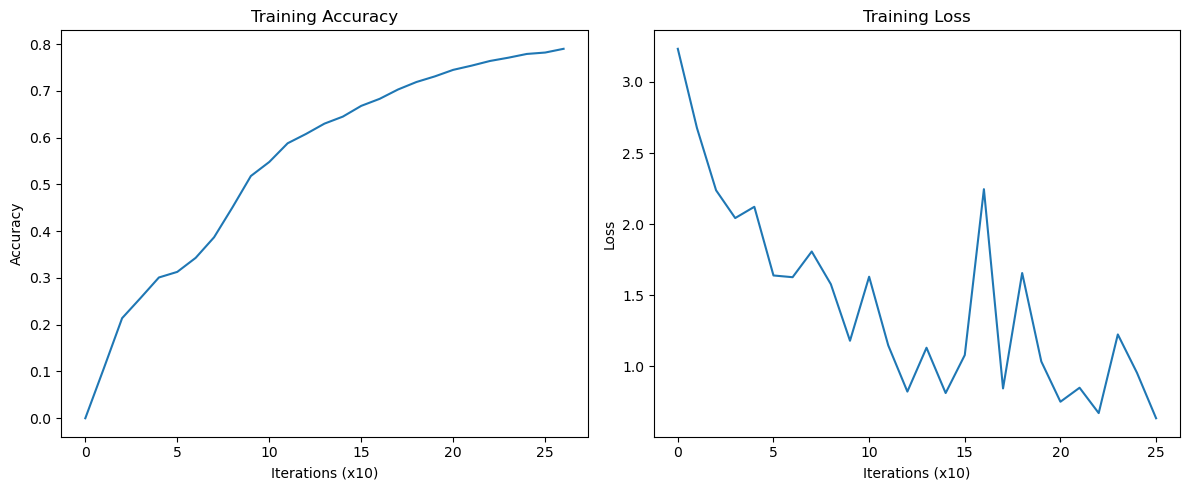

Iteration: 260
Accuracy: 0.793
Loss: 0.5660081849921119


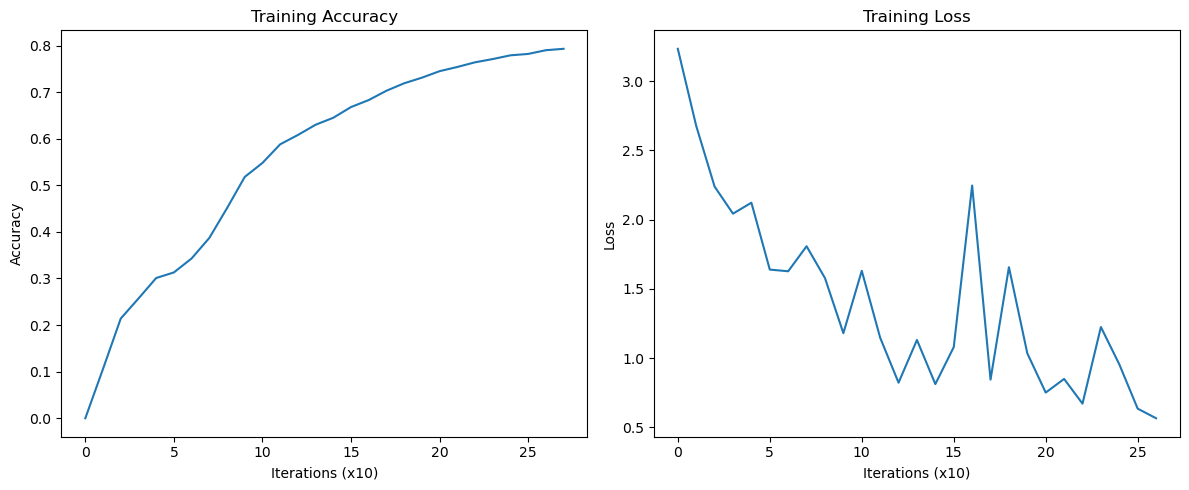

Iteration: 270
Accuracy: 0.796
Loss: 0.5951783939217916


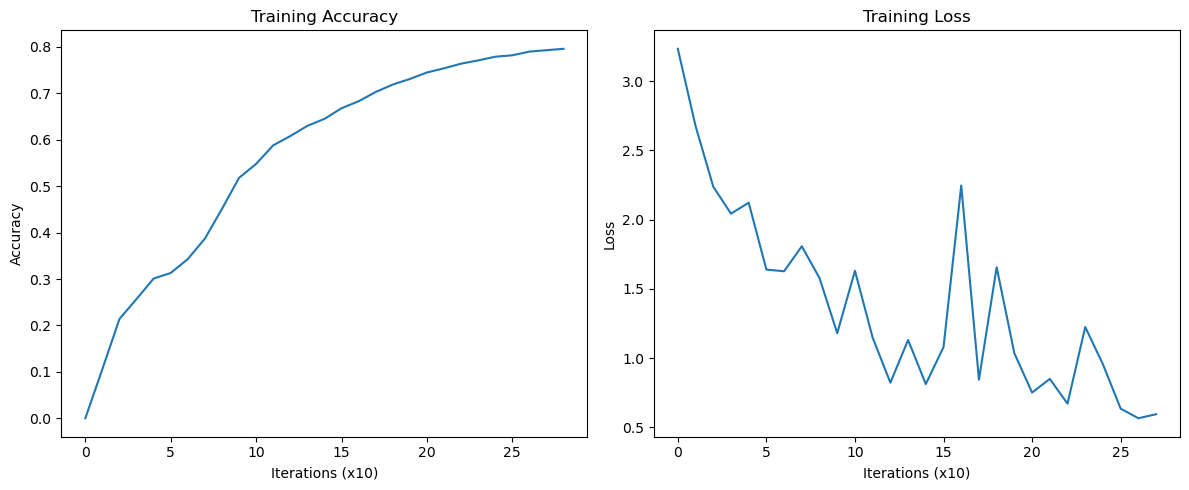

Iteration: 280
Accuracy: 0.8
Loss: 1.735552454993099


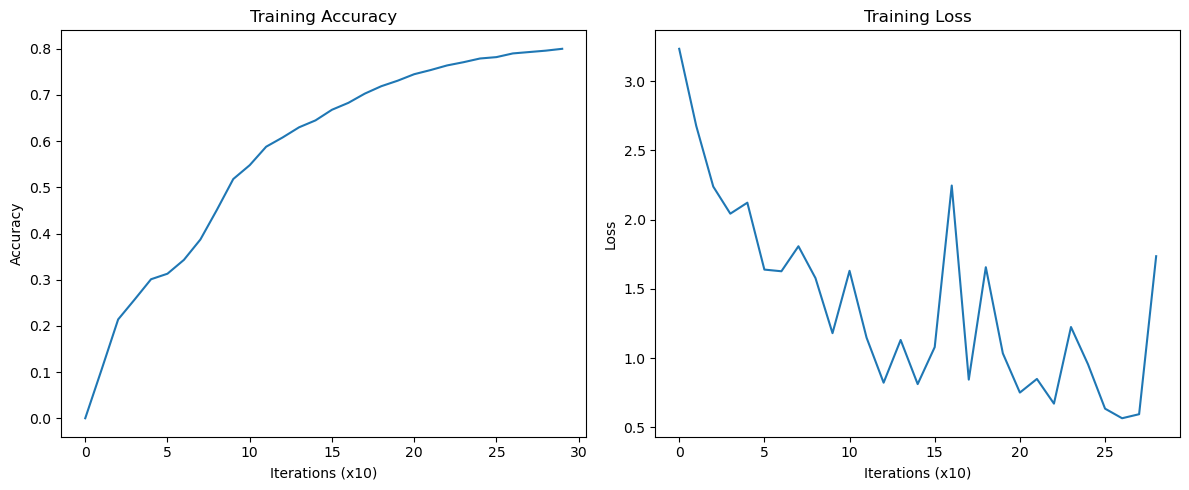

Iteration: 290
Accuracy: 0.807
Loss: 0.7192296100790766


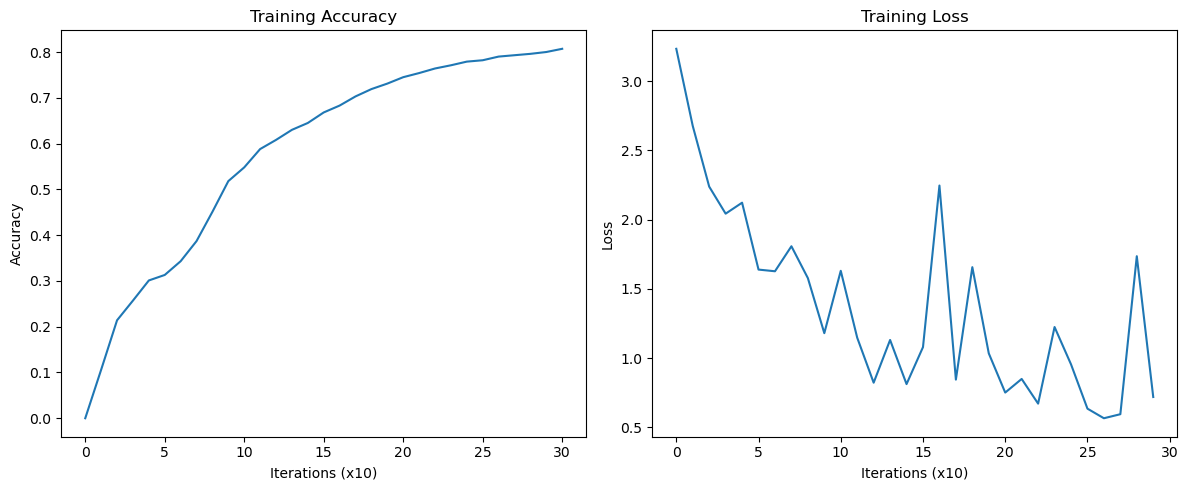

Iteration: 300
Accuracy: 0.807
Loss: 0.5465918534658177


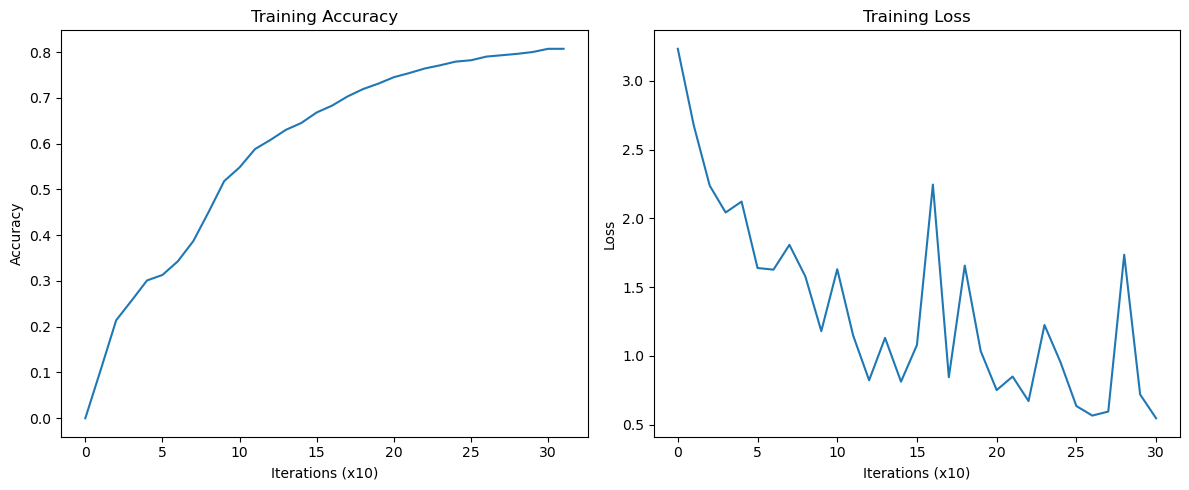

Iteration: 310
Accuracy: 0.81
Loss: 0.8058185483650357


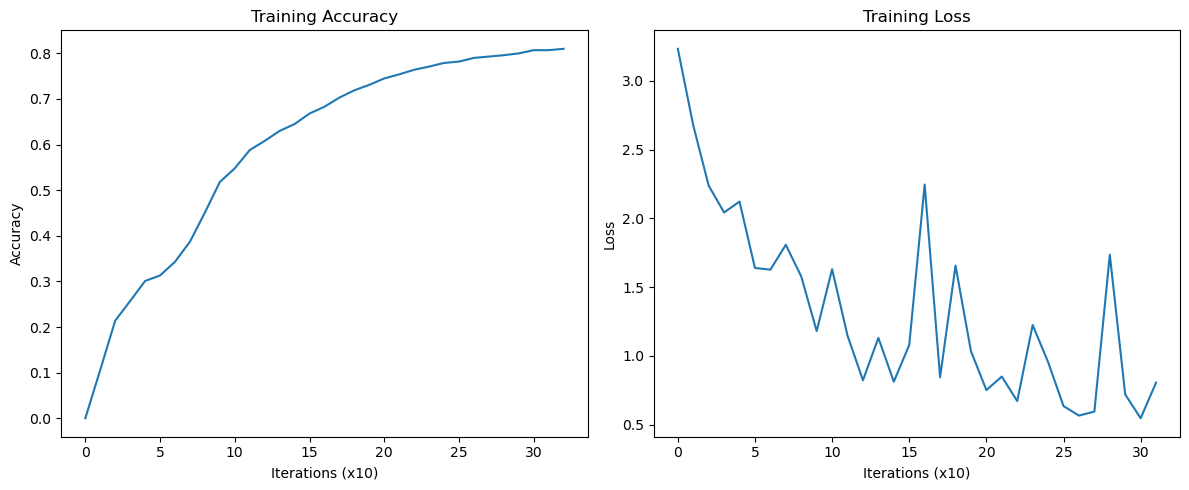

Iteration: 320
Accuracy: 0.816
Loss: 0.47544757627246526


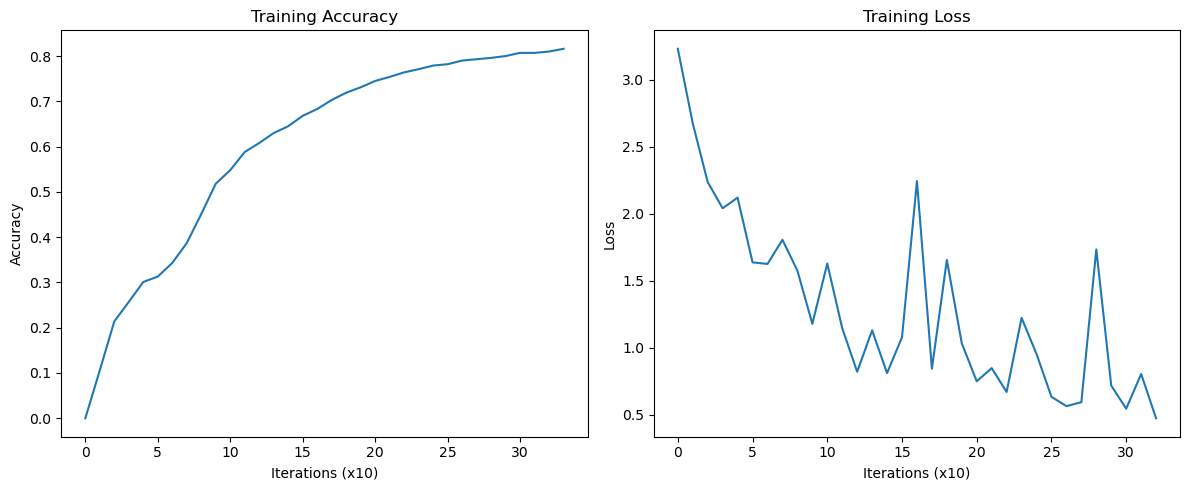

Iteration: 330
Accuracy: 0.817
Loss: 0.2100159527790371


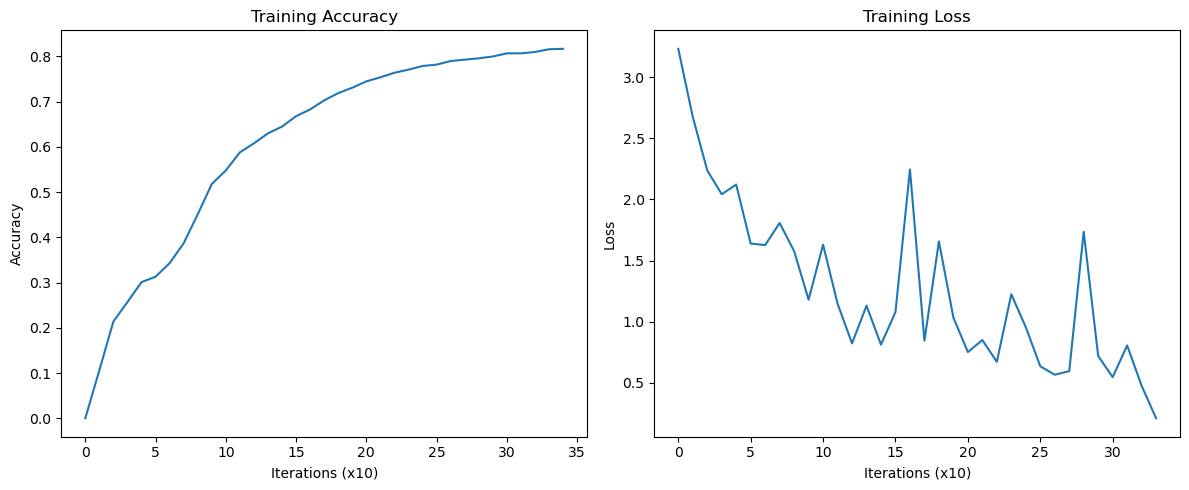

Iteration: 340
Accuracy: 0.819
Loss: 0.37750261925092604


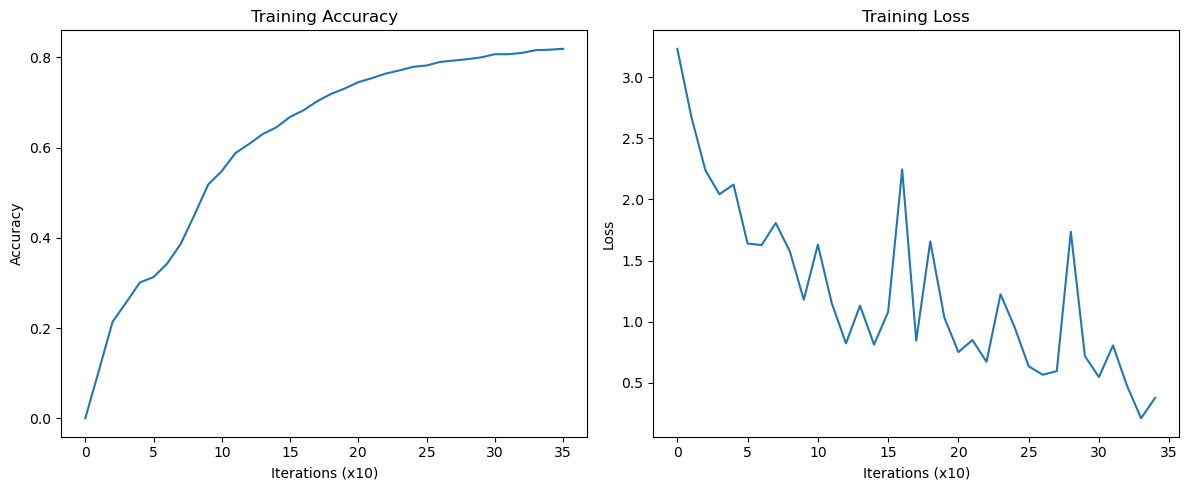

Iteration: 350
Accuracy: 0.826
Loss: 0.6487940238105169


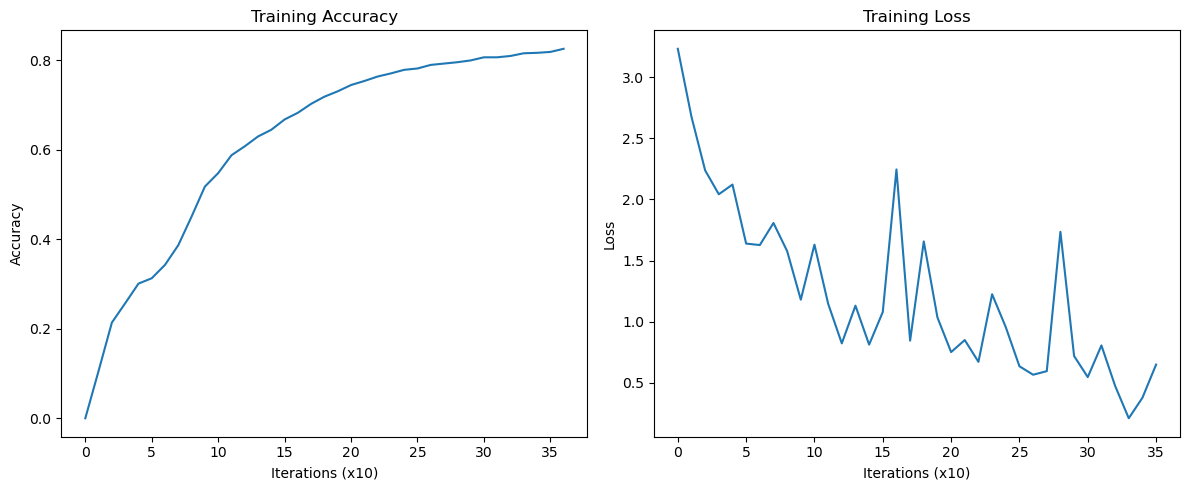

Iteration: 360
Accuracy: 0.829
Loss: 0.23216934000256848


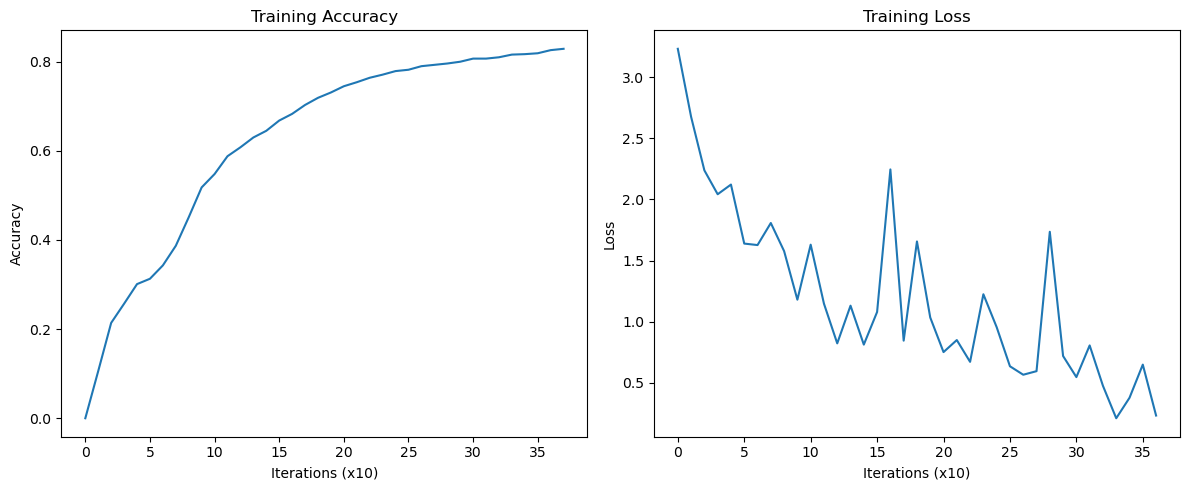

Iteration: 370
Accuracy: 0.832
Loss: 0.7133306638073964


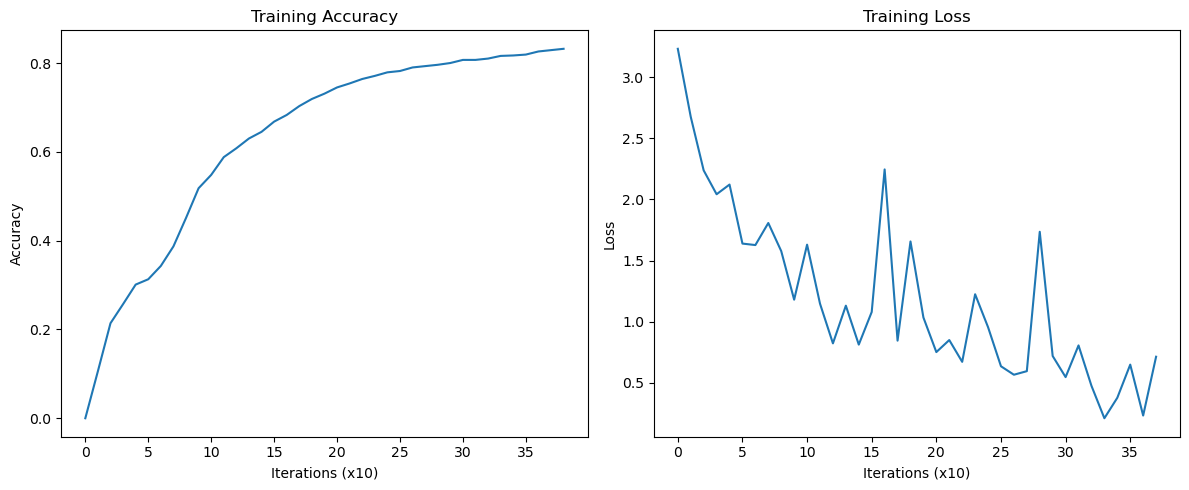

Iteration: 380
Accuracy: 0.836
Loss: 0.3539079592906112


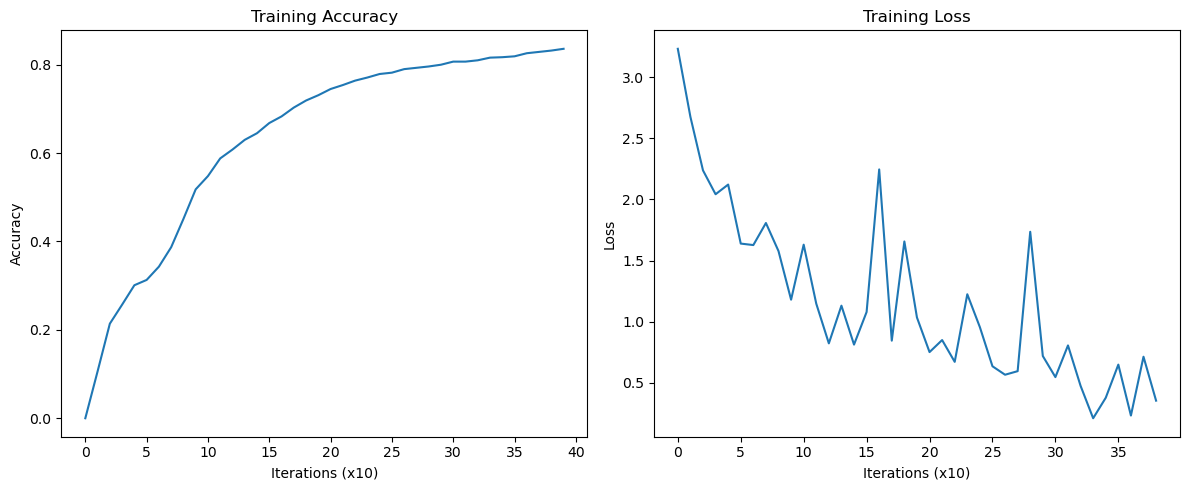

Iteration: 390
Accuracy: 0.839
Loss: 0.5684117493191633


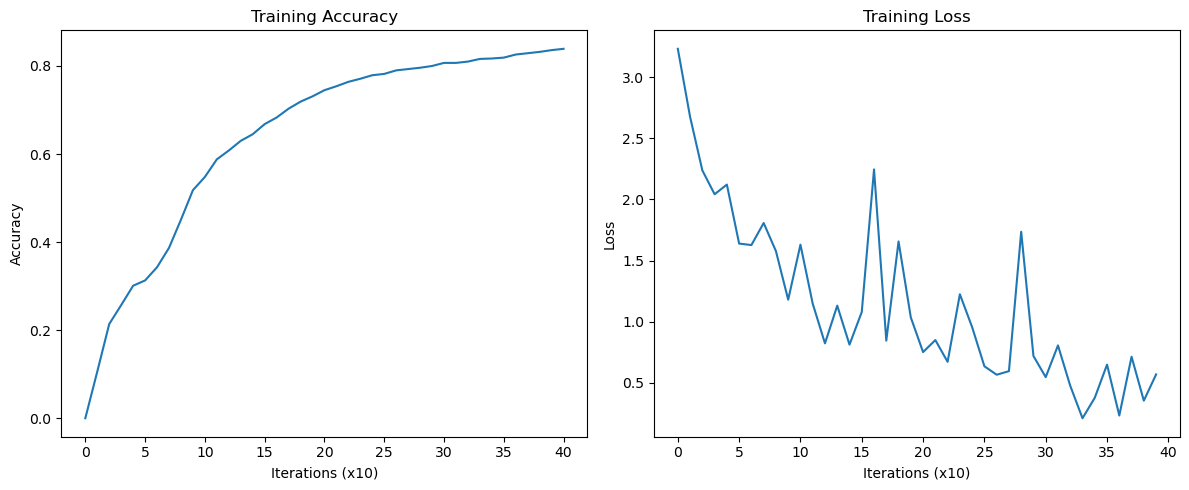

Iteration: 400
Accuracy: 0.842
Loss: 0.3962666011969662


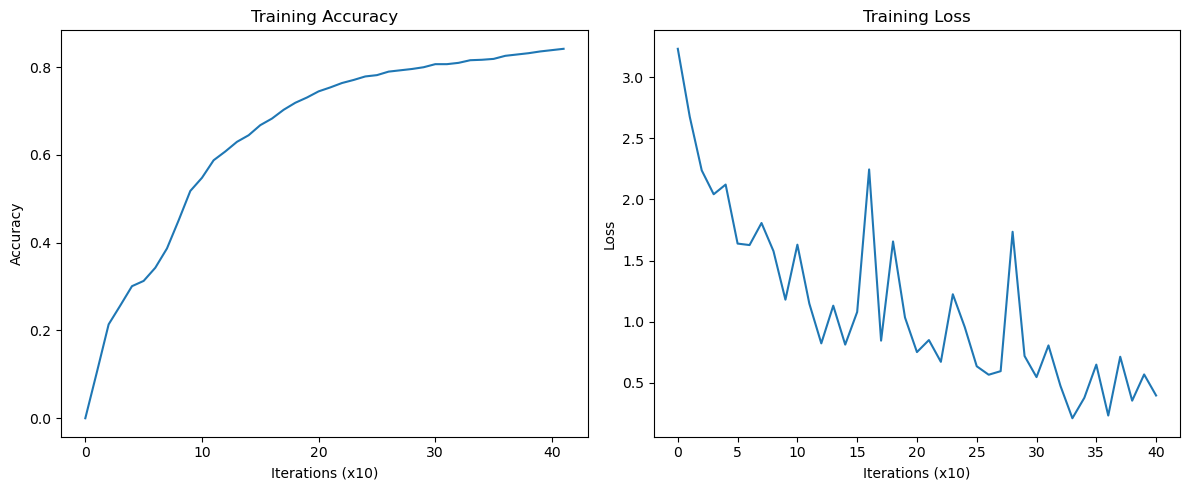

Iteration: 410
Accuracy: 0.845
Loss: 0.37926963322843843


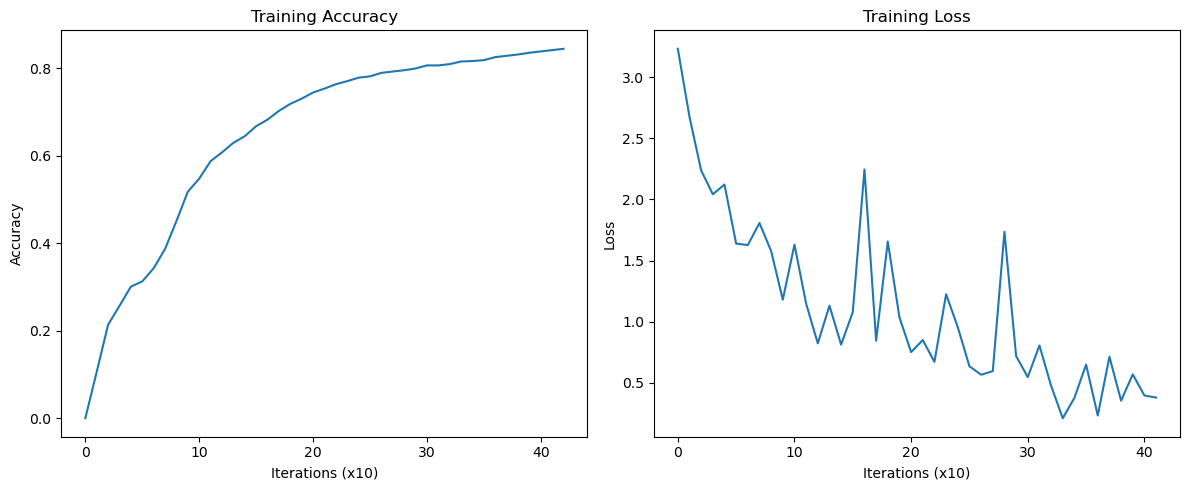

Iteration: 420
Accuracy: 0.845
Loss: 0.28038468567210606


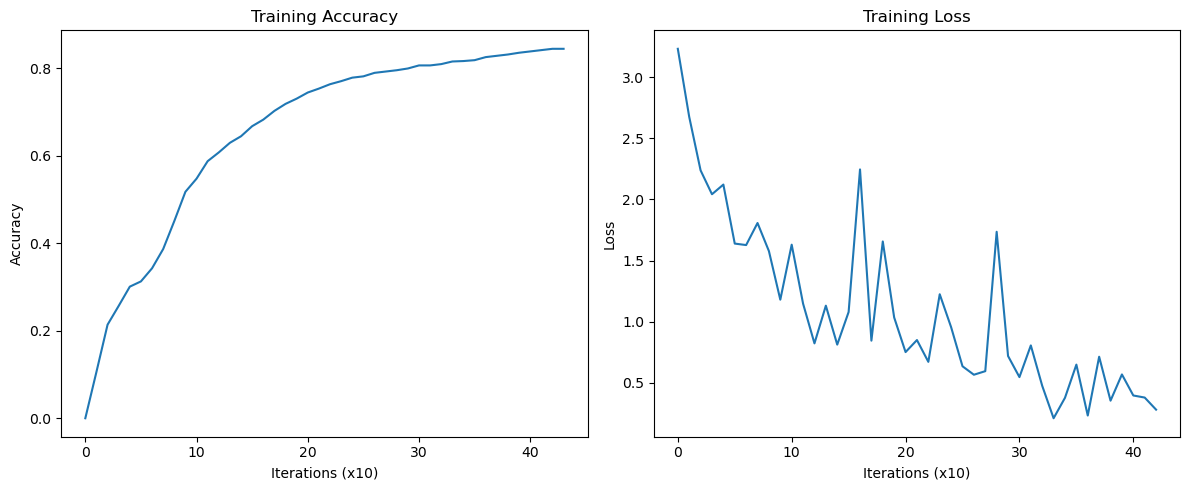

Iteration: 430
Accuracy: 0.847
Loss: 0.7492451146983508


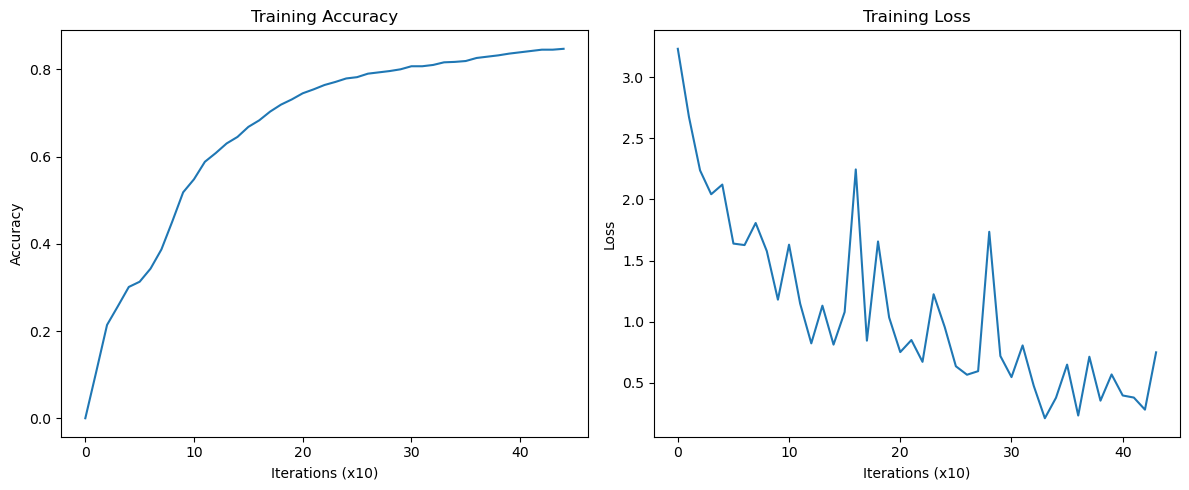

Iteration: 440
Accuracy: 0.849
Loss: 1.331784357650005


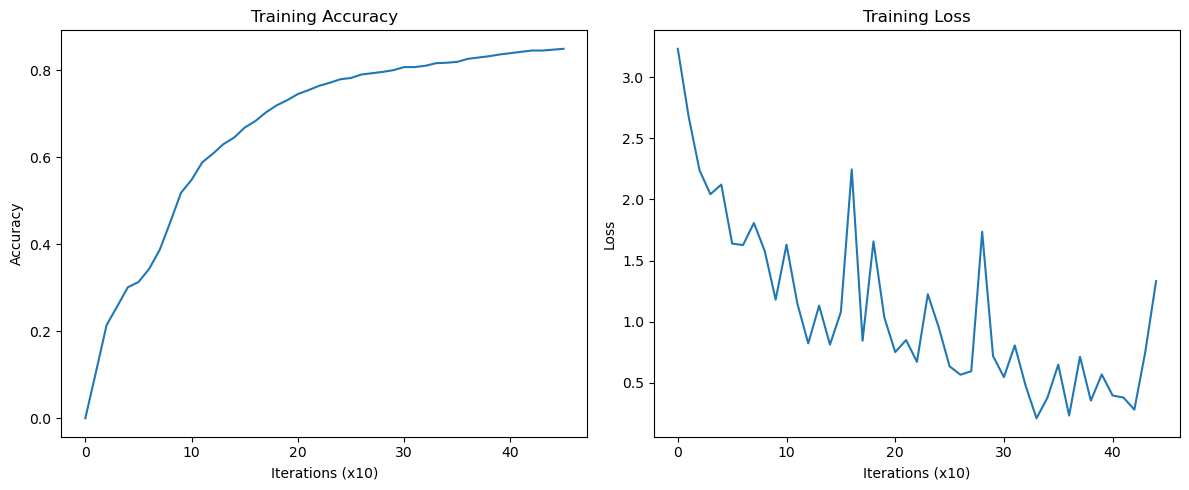

Iteration: 450
Accuracy: 0.851
Loss: 0.4993961015480516


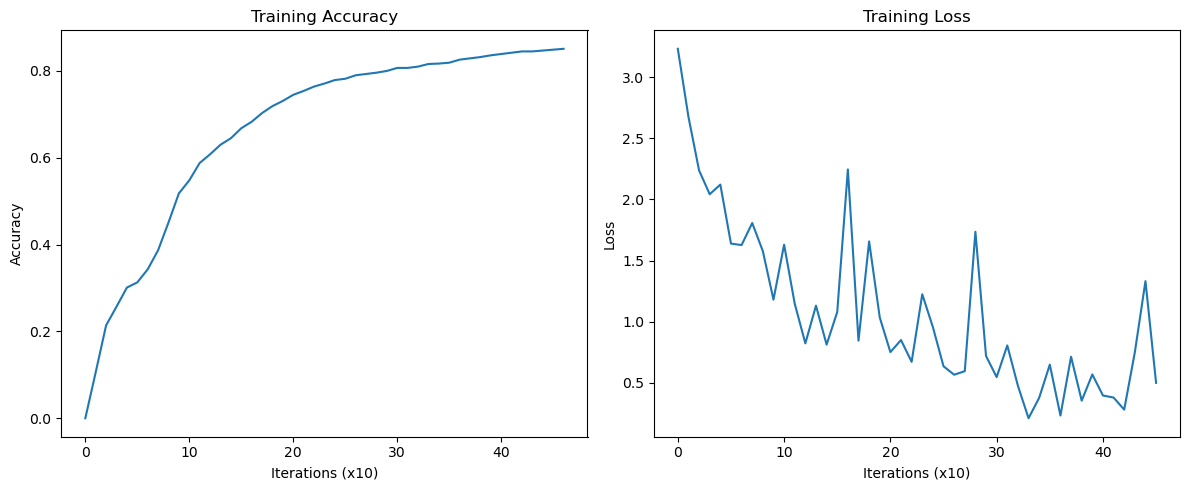

Iteration: 460
Accuracy: 0.852
Loss: 0.4550688947149119


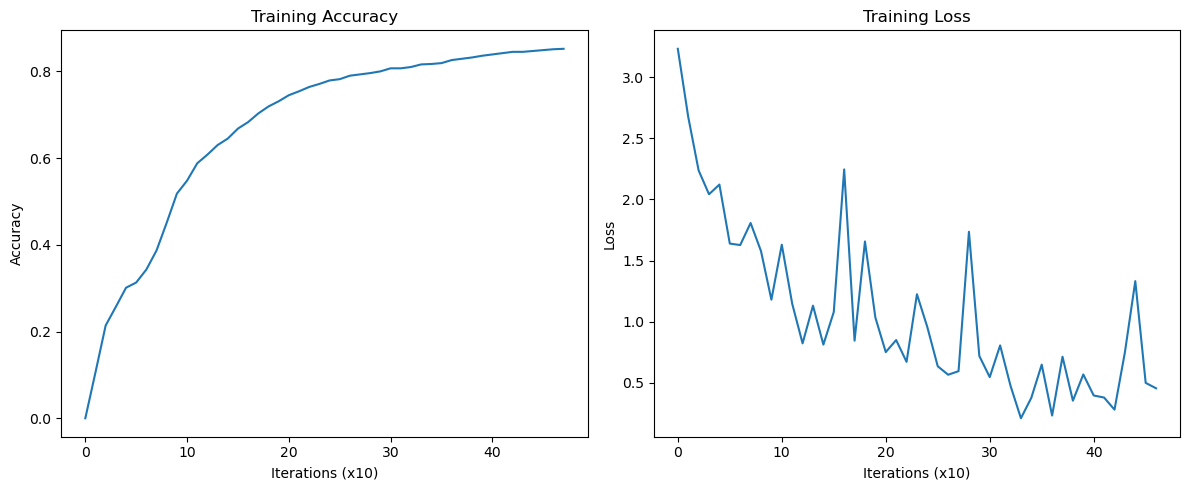

Iteration: 470
Accuracy: 0.852
Loss: 0.21357224790031826


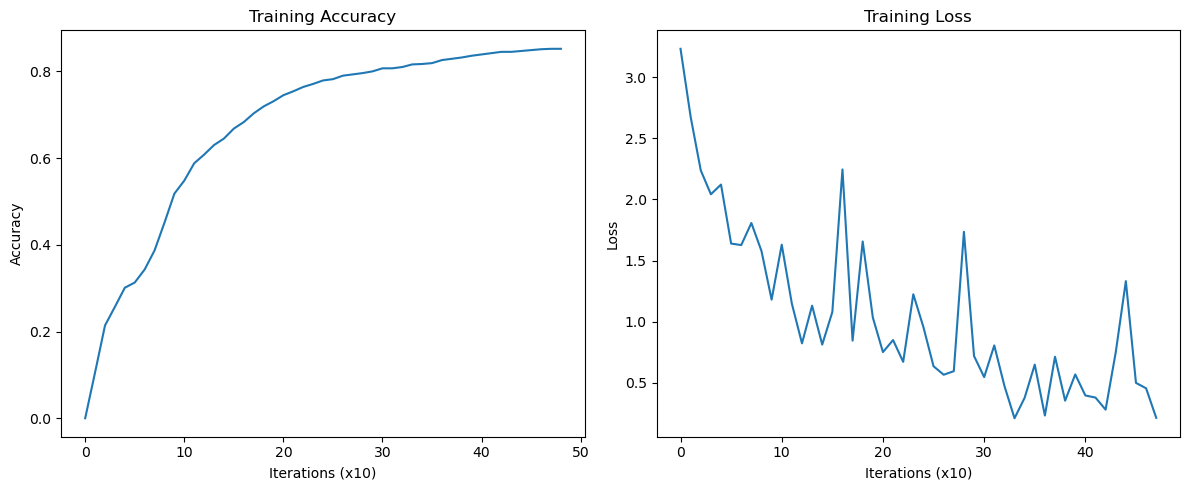

Iteration: 480
Accuracy: 0.853
Loss: 0.6437209594037554


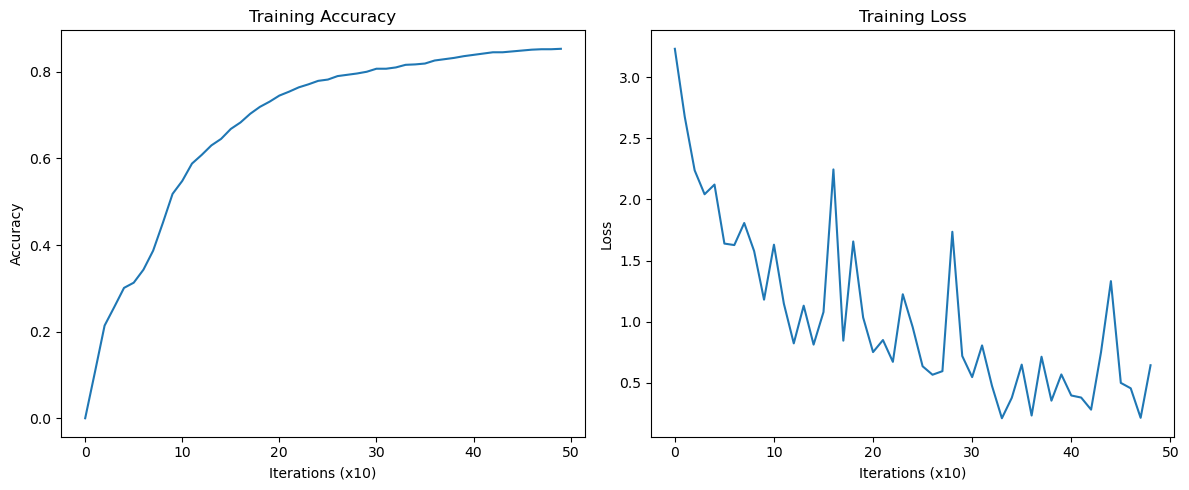

Iteration: 490
Accuracy: 0.855
Loss: 0.20855388499558744


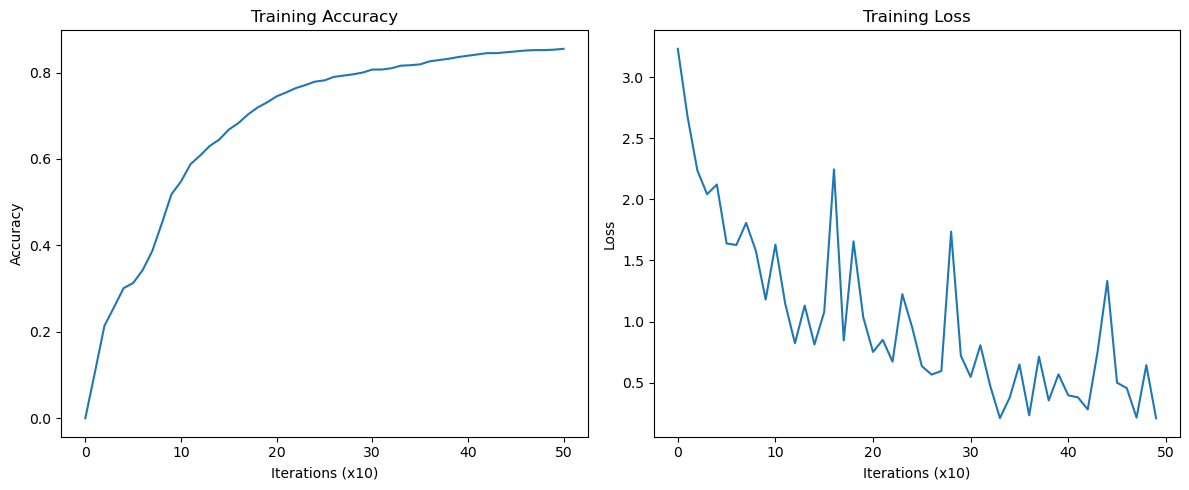

Iteration: 500
Accuracy: 0.856
Loss: 0.7996592827635094


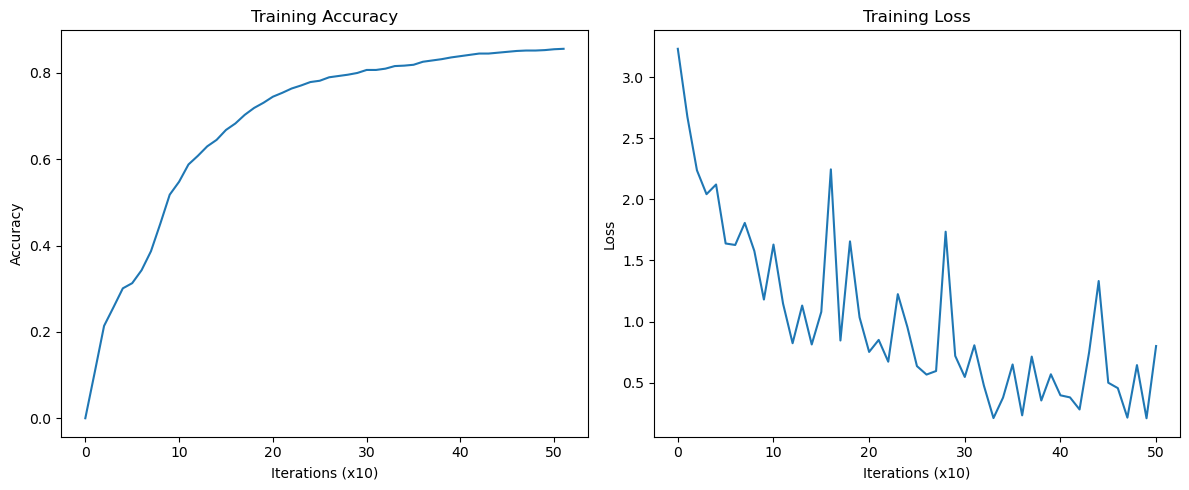

Iteration: 510
Accuracy: 0.859
Loss: 0.48362012548726585


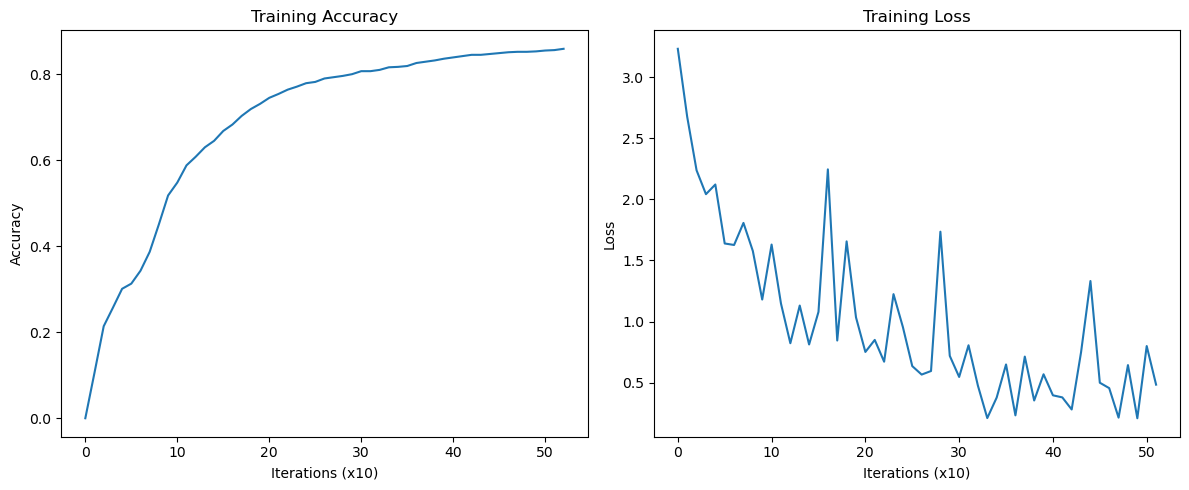

Iteration: 520
Accuracy: 0.859
Loss: 0.015829712321941507


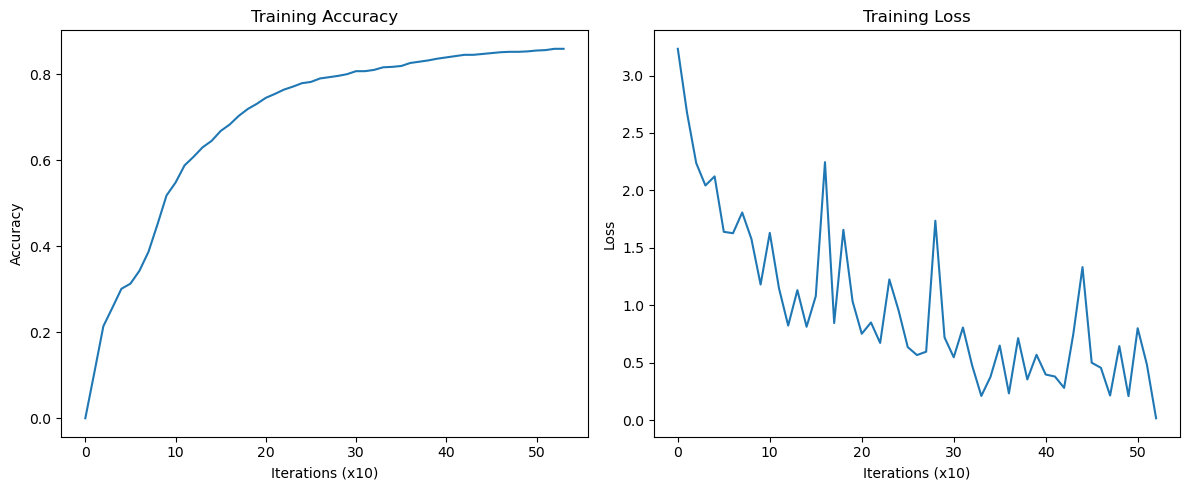

Iteration: 530
Accuracy: 0.857
Loss: 0.18739085336012357


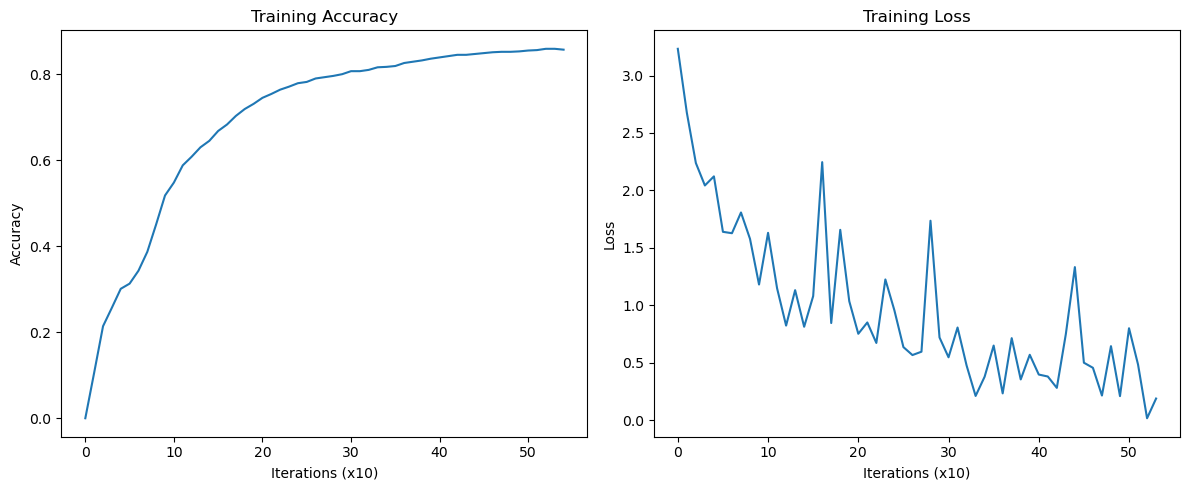

Iteration: 540
Accuracy: 0.859
Loss: 0.24551547717771058


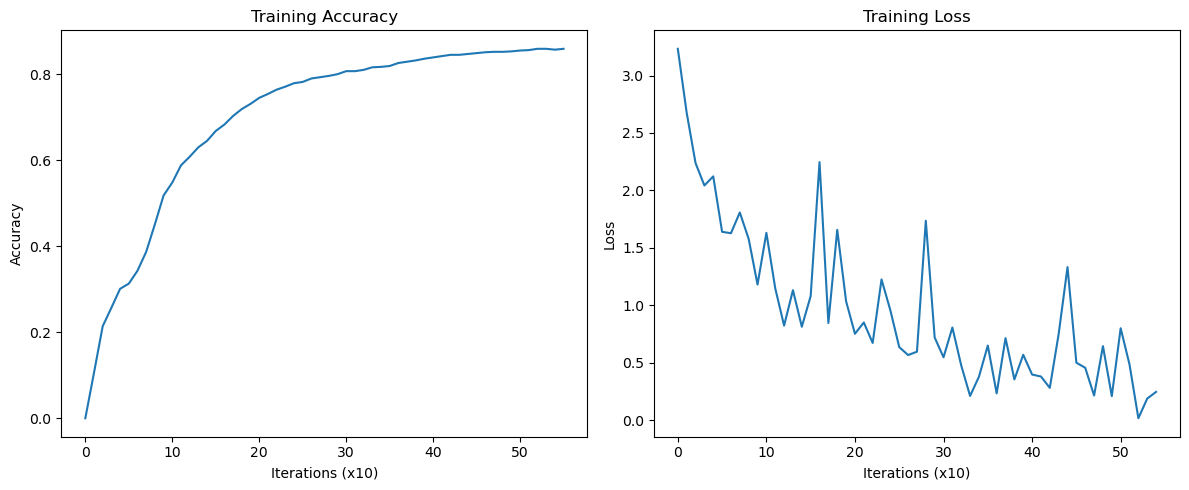

Iteration: 550
Accuracy: 0.861
Loss: 0.35803802723675654


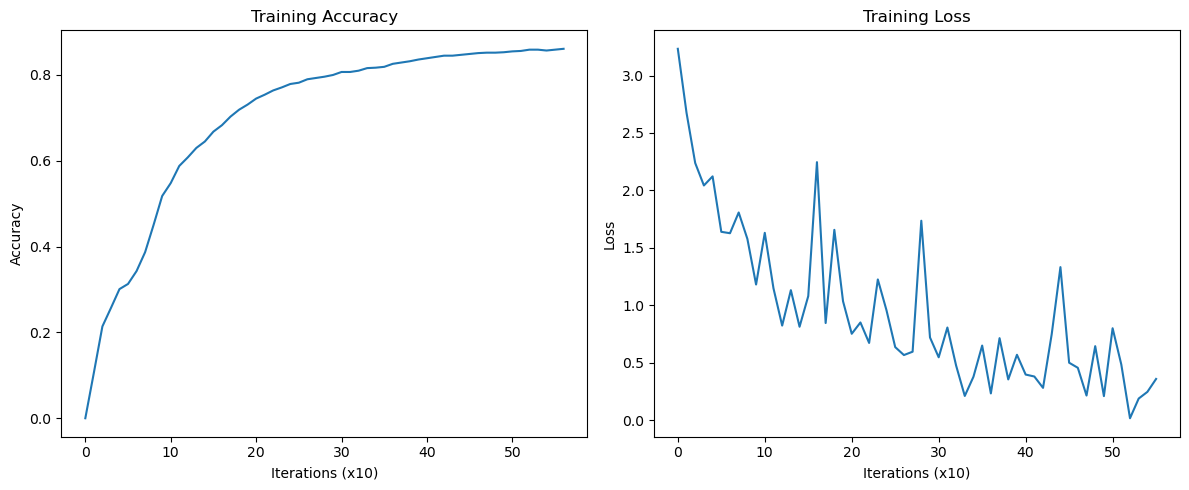

Iteration: 560
Accuracy: 0.862
Loss: 0.24499289797632687


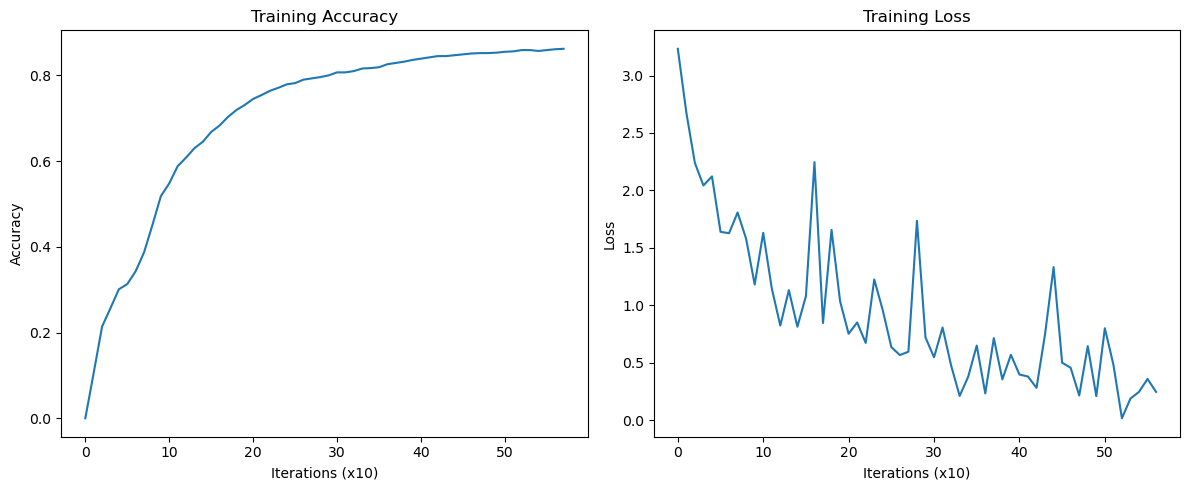

Iteration: 570
Accuracy: 0.862
Loss: 0.6930591854376924


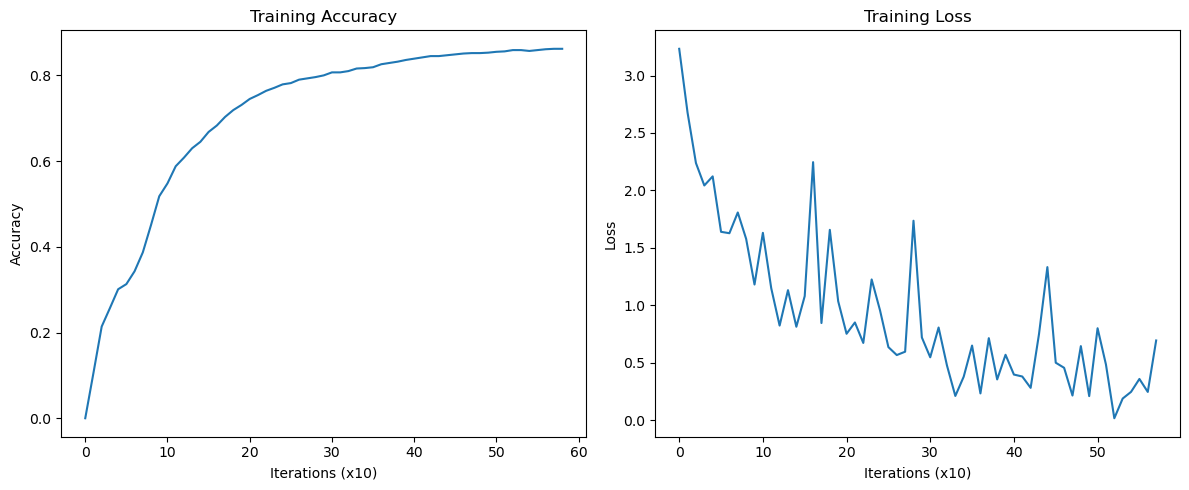

Iteration: 580
Accuracy: 0.863
Loss: 0.2362995074299207


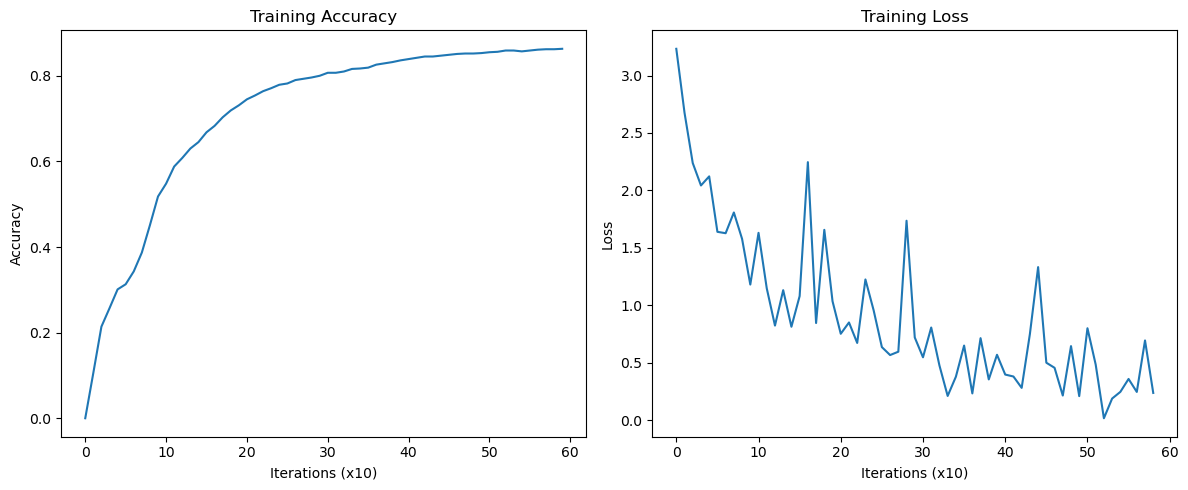

Iteration: 590
Accuracy: 0.864
Loss: 0.3529546320466964


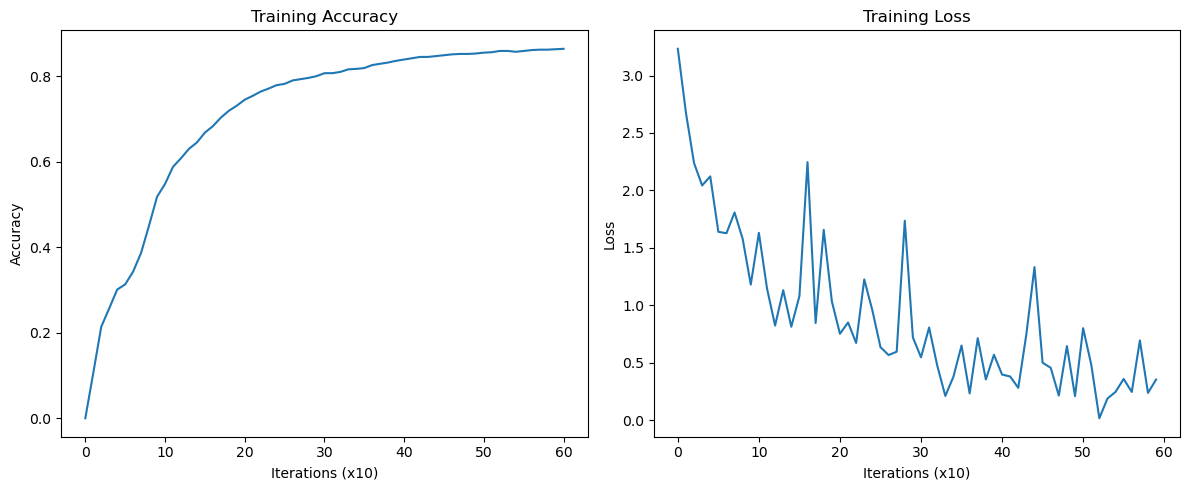

Iteration: 600
Accuracy: 0.866
Loss: 0.8993737547095368


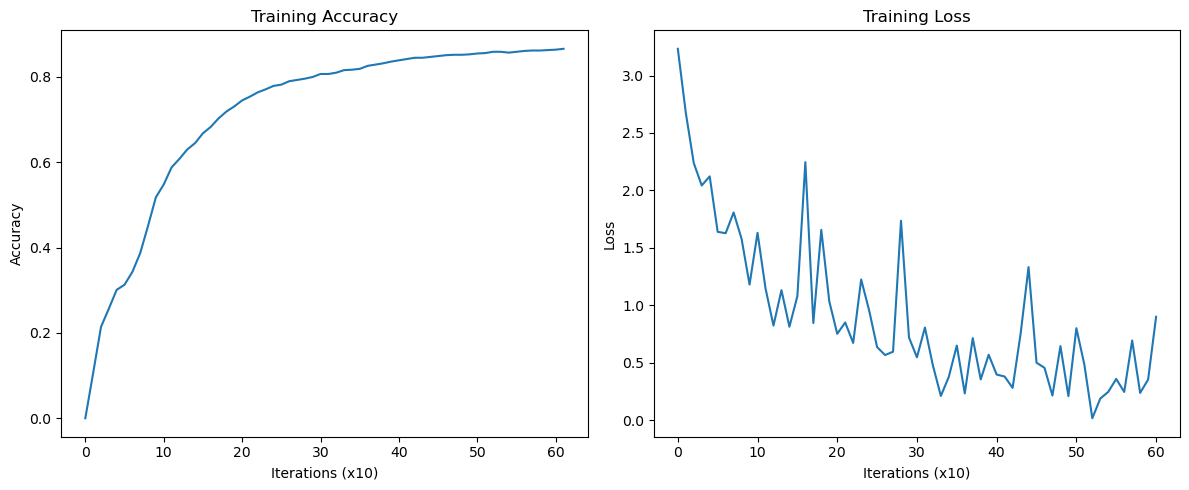

Iteration: 610
Accuracy: 0.866
Loss: 1.0011757888266697


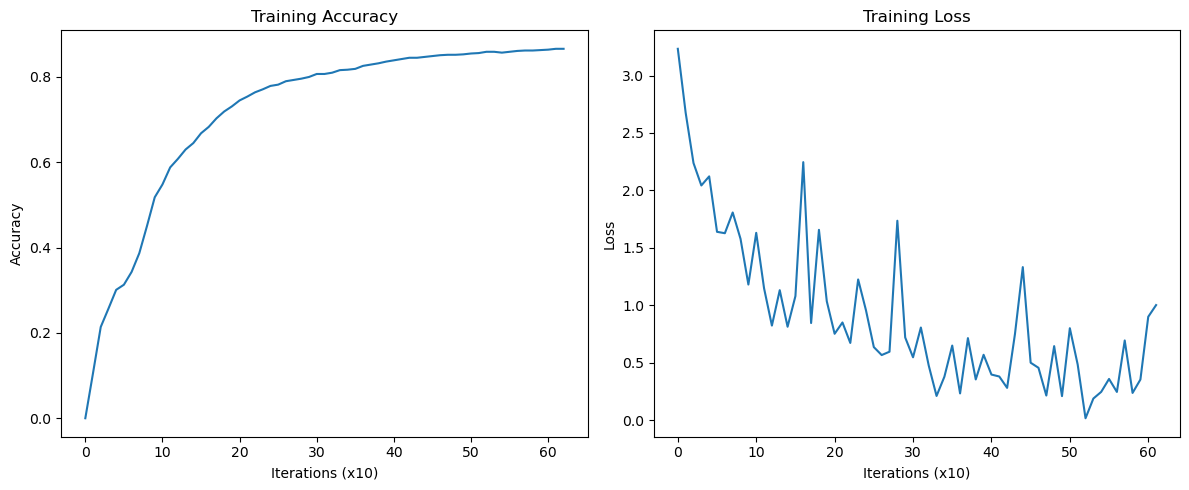

Iteration: 620
Accuracy: 0.866
Loss: 1.762272042073258


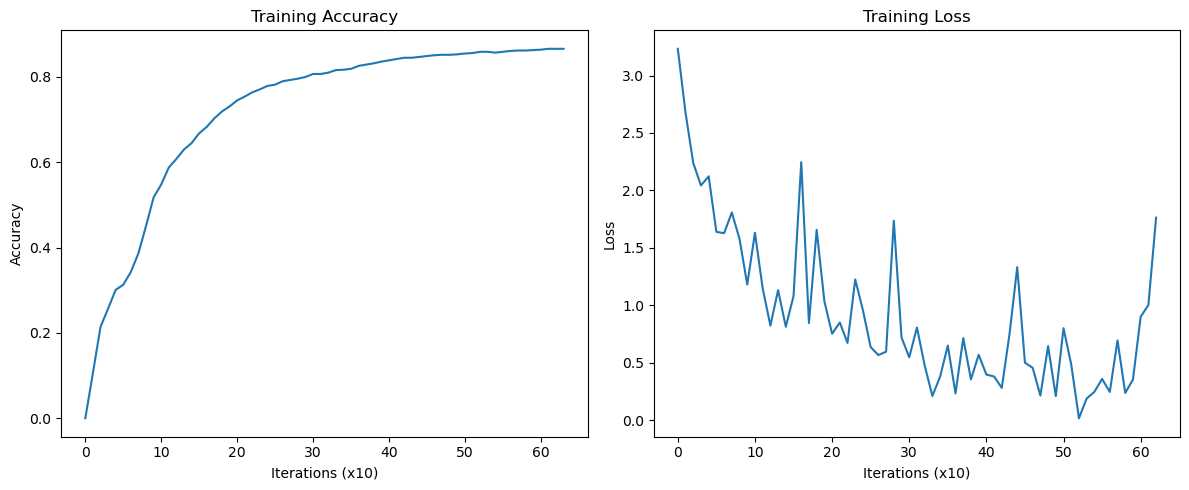

Iteration: 630
Accuracy: 0.866
Loss: 0.04981143603899893


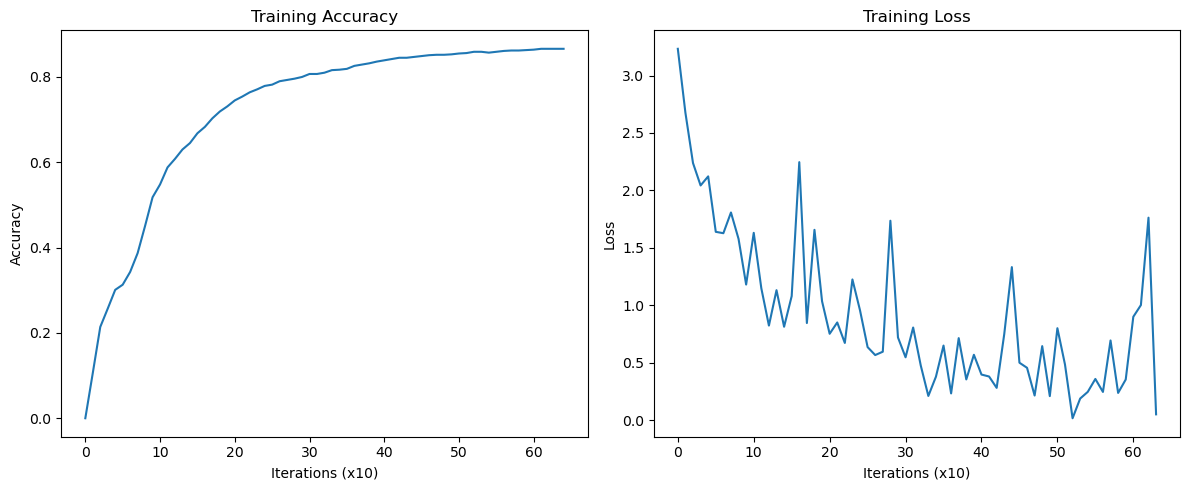

Iteration: 640
Accuracy: 0.866
Loss: 0.7523260070504364


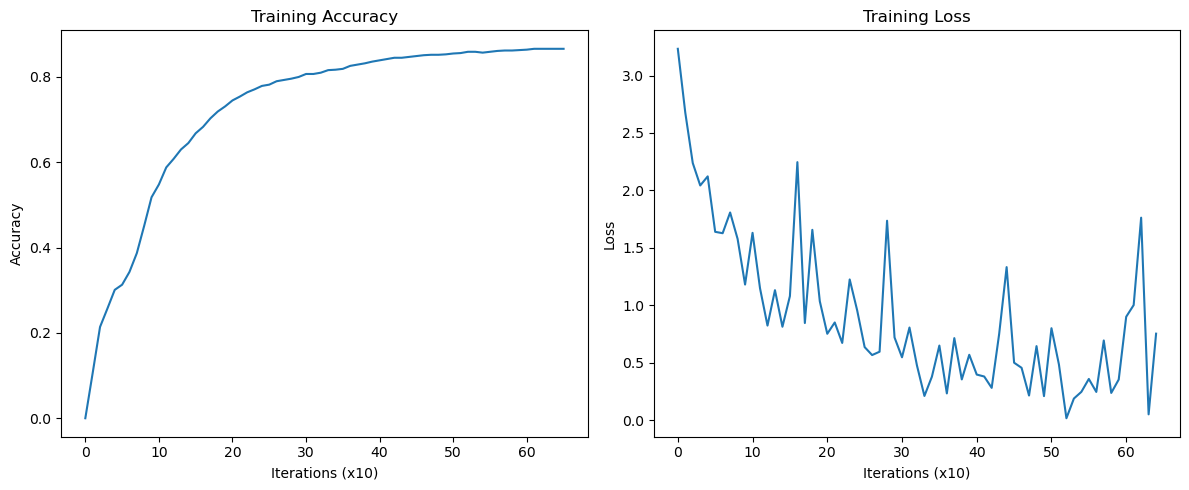

Iteration: 650
Accuracy: 0.866
Loss: 0.9227624933708354


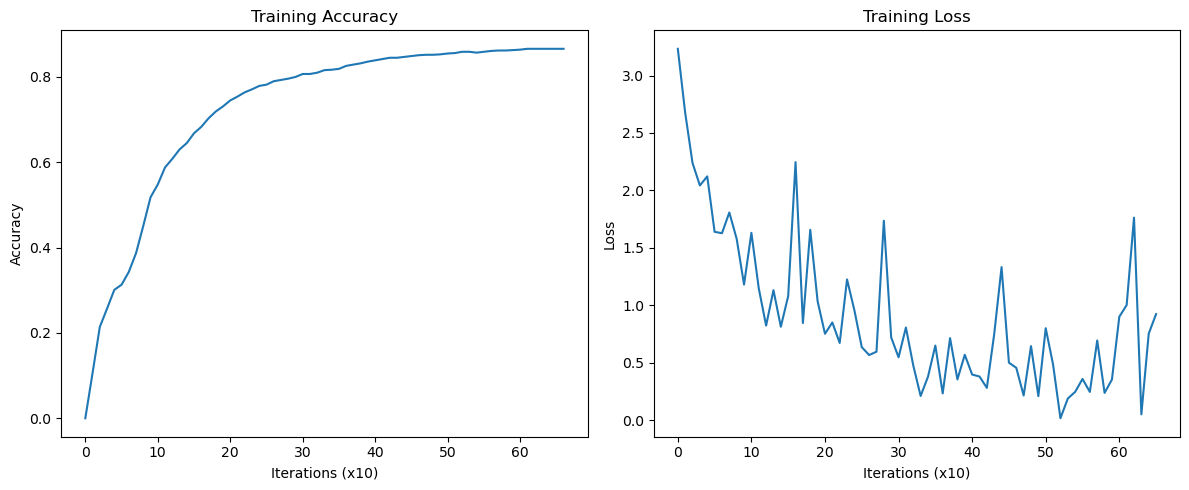

Iteration: 660
Accuracy: 0.866
Loss: 0.6240856729016795


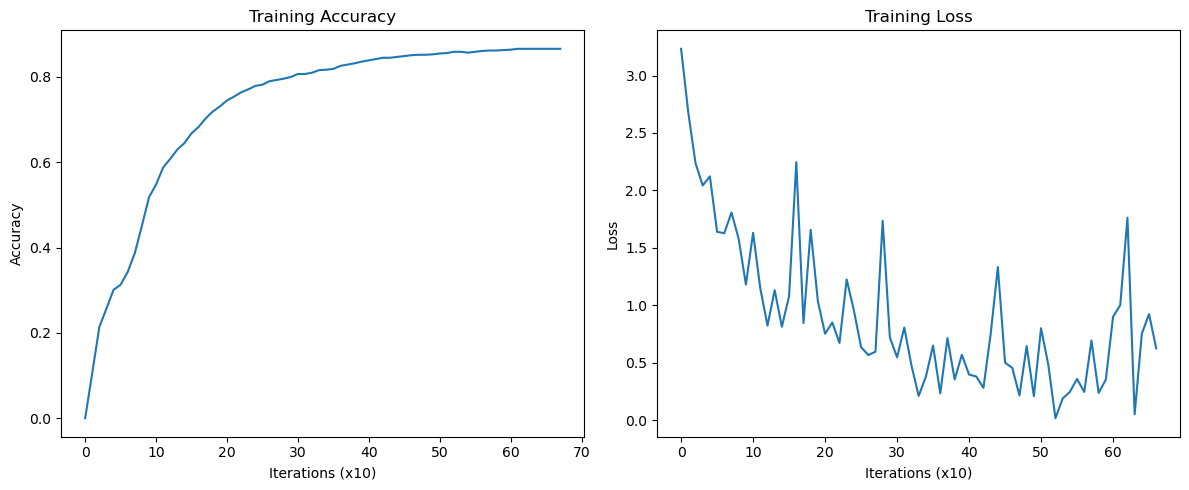

Iteration: 670
Accuracy: 0.866
Loss: 0.1234053165856969


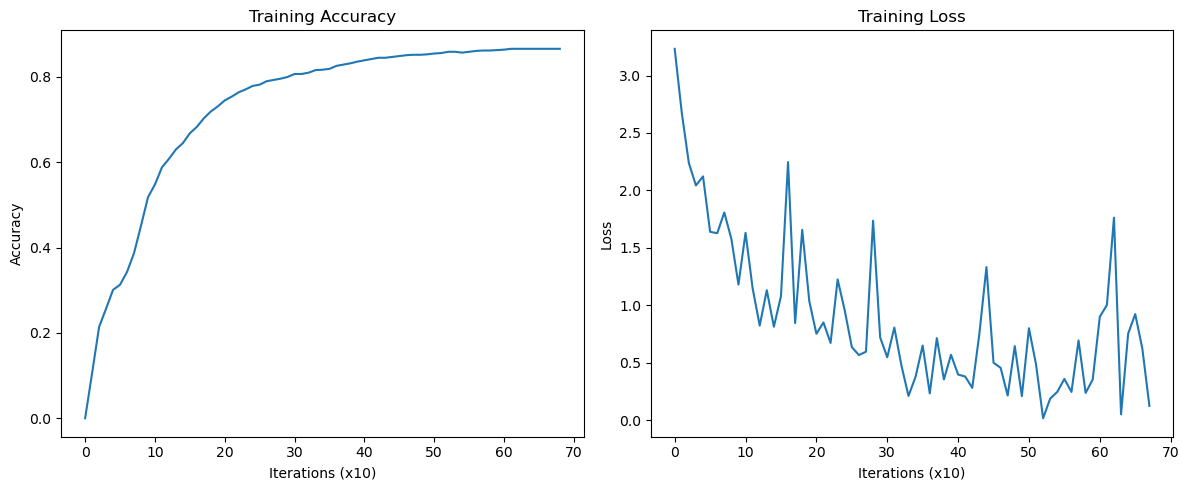

Iteration: 680
Accuracy: 0.867
Loss: 0.1428847473808261


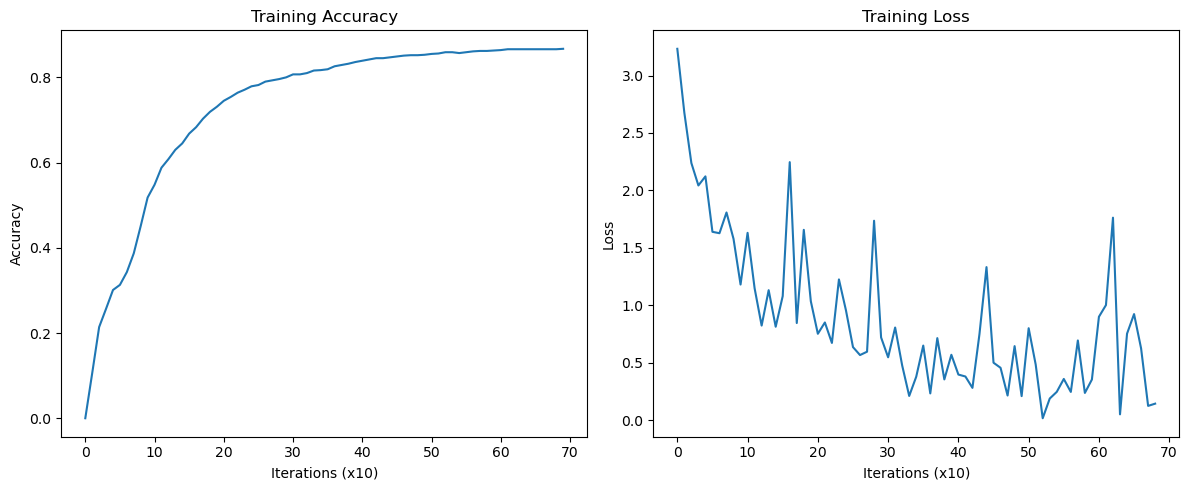

Iteration: 690
Accuracy: 0.866
Loss: 0.37436352616992724


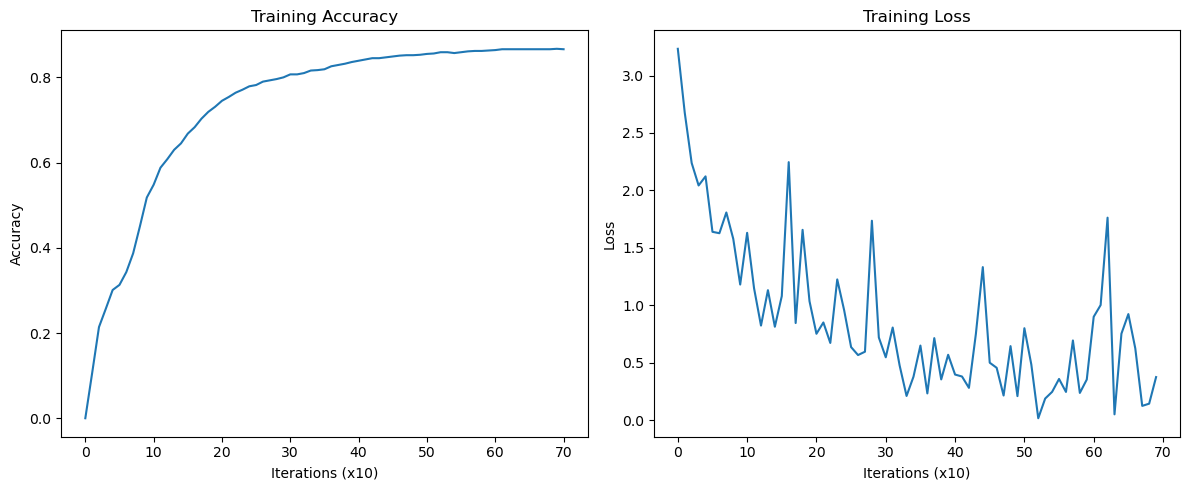

Iteration: 700
Accuracy: 0.867
Loss: 0.13919642521167475


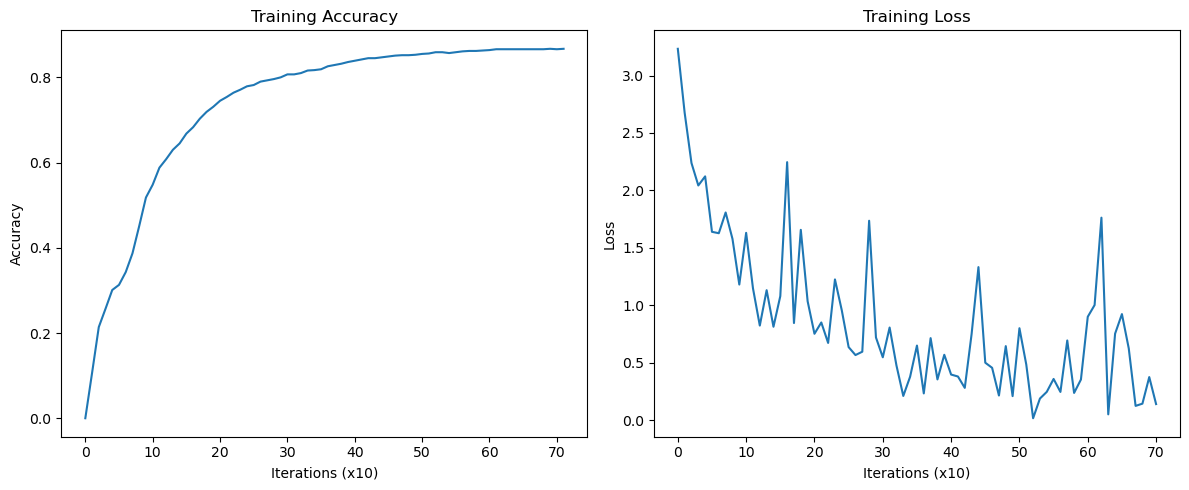

Iteration: 710
Accuracy: 0.867
Loss: 0.4054479226427614


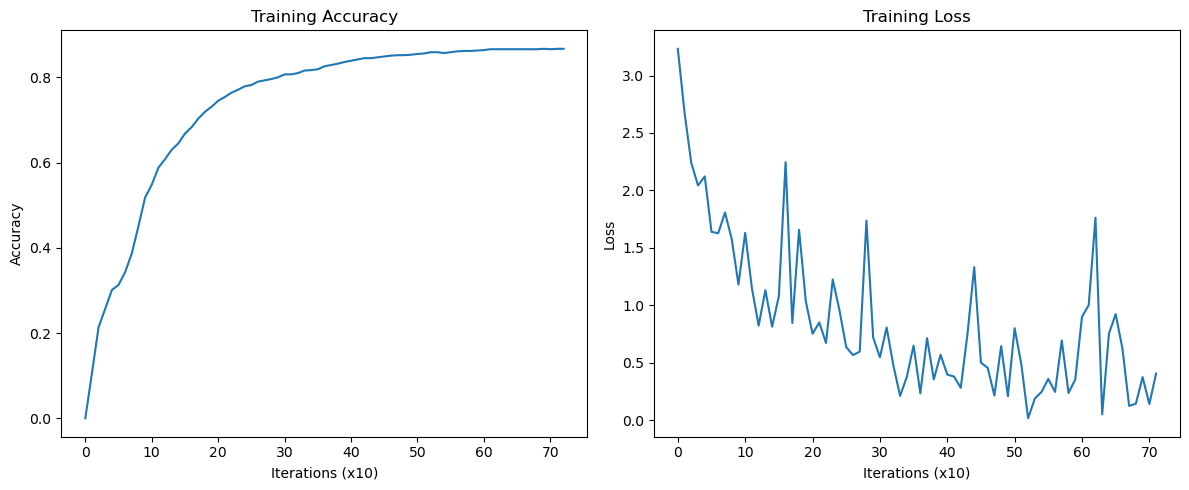

Iteration: 720
Accuracy: 0.869
Loss: 0.10154737266742939


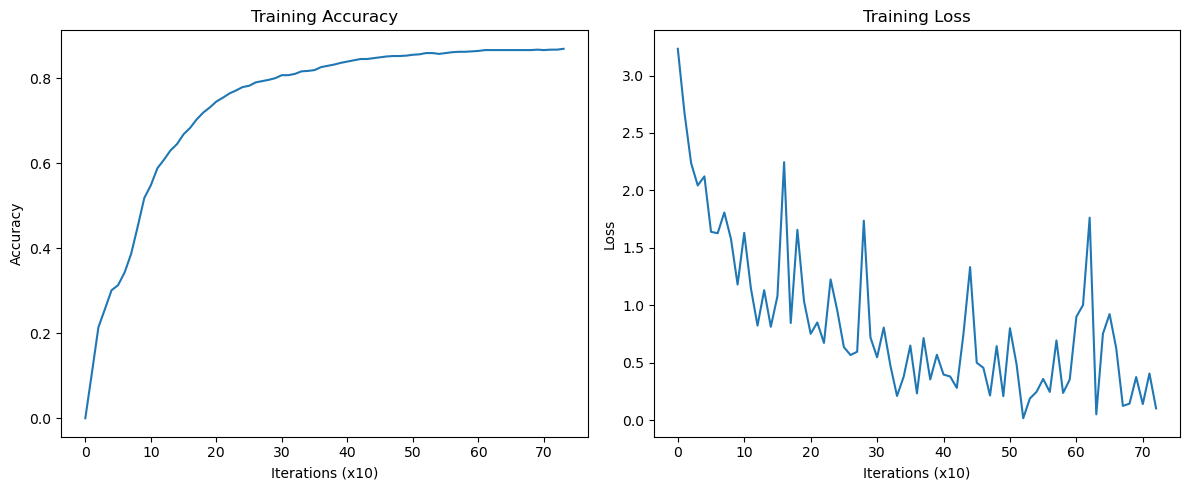

Iteration: 730
Accuracy: 0.869
Loss: 0.03759503075690379


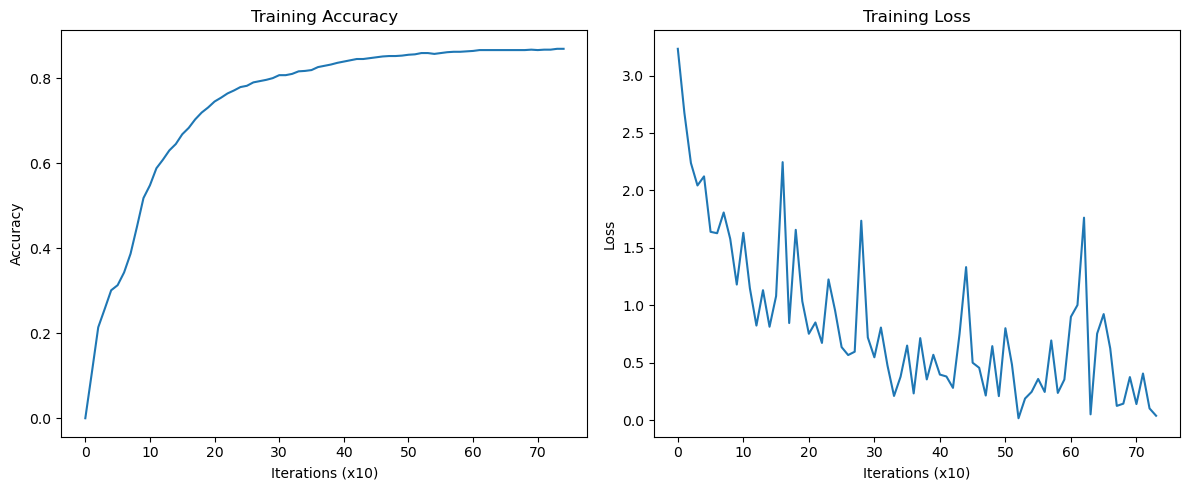

Iteration: 740
Accuracy: 0.87
Loss: 0.8299813415352988


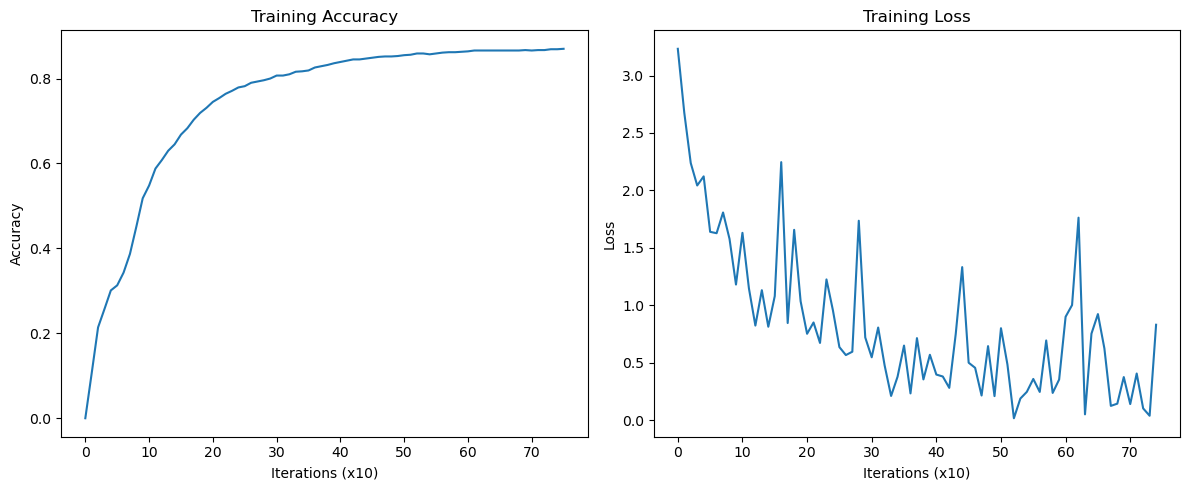

Iteration: 750
Accuracy: 0.869
Loss: 0.08407027404206979


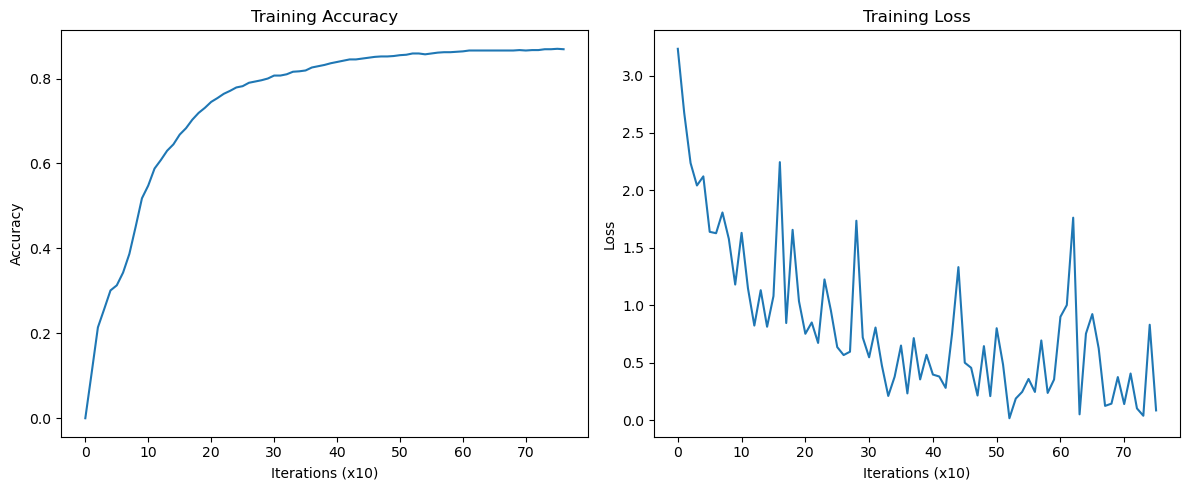

Iteration: 760
Accuracy: 0.869
Loss: 0.541280977155918


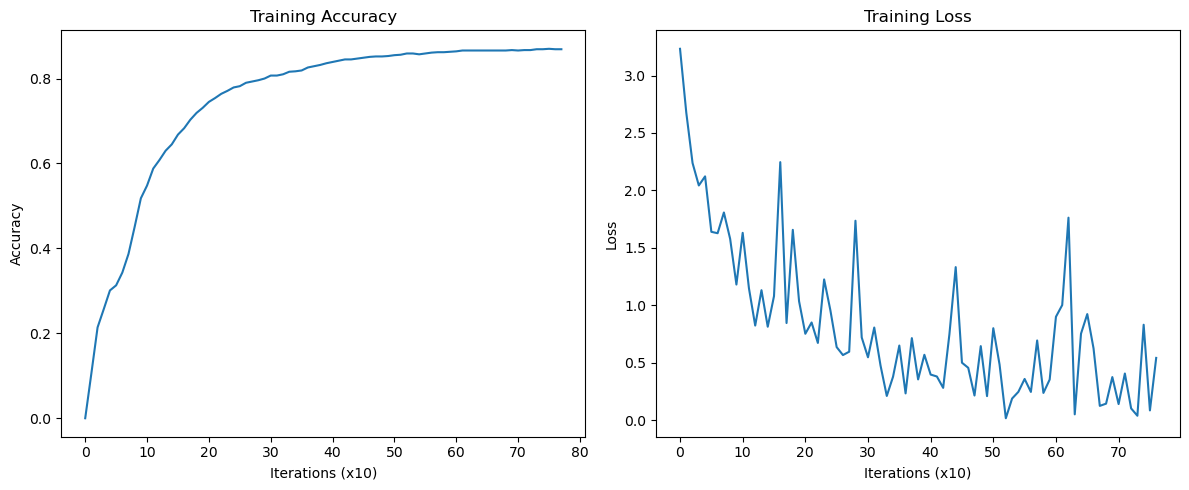

Iteration: 770
Accuracy: 0.869
Loss: 0.25614777956073725


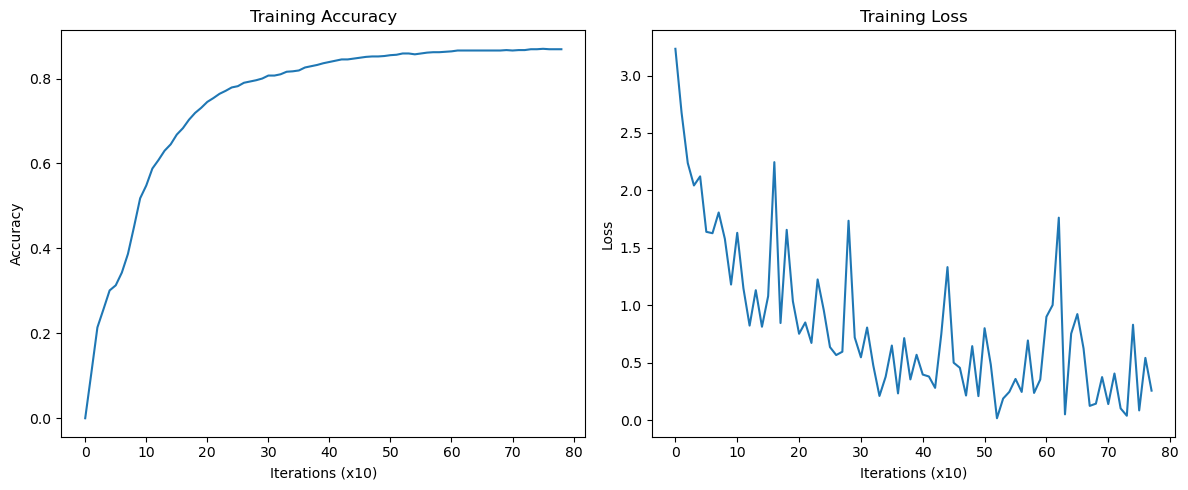

Iteration: 780
Accuracy: 0.872
Loss: 1.1797542373403602


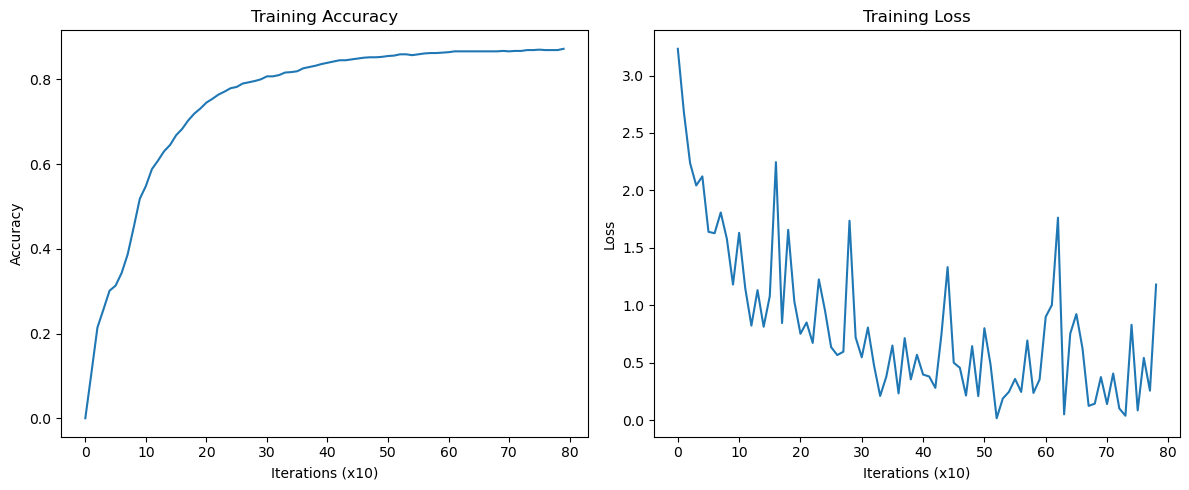

Iteration: 790
Accuracy: 0.875
Loss: 0.5643273461623047


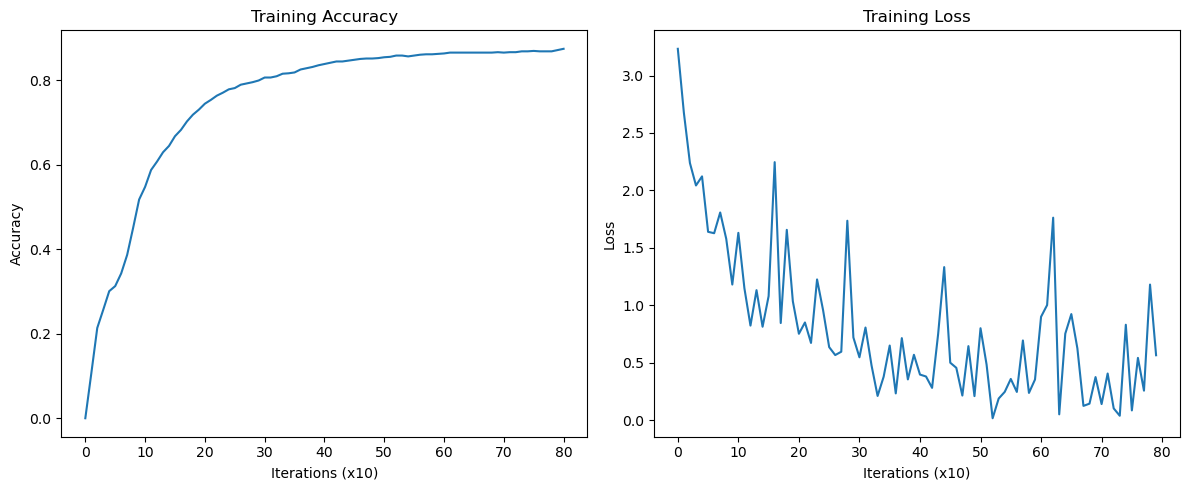

Iteration: 800
Accuracy: 0.875
Loss: 0.3335477328231282


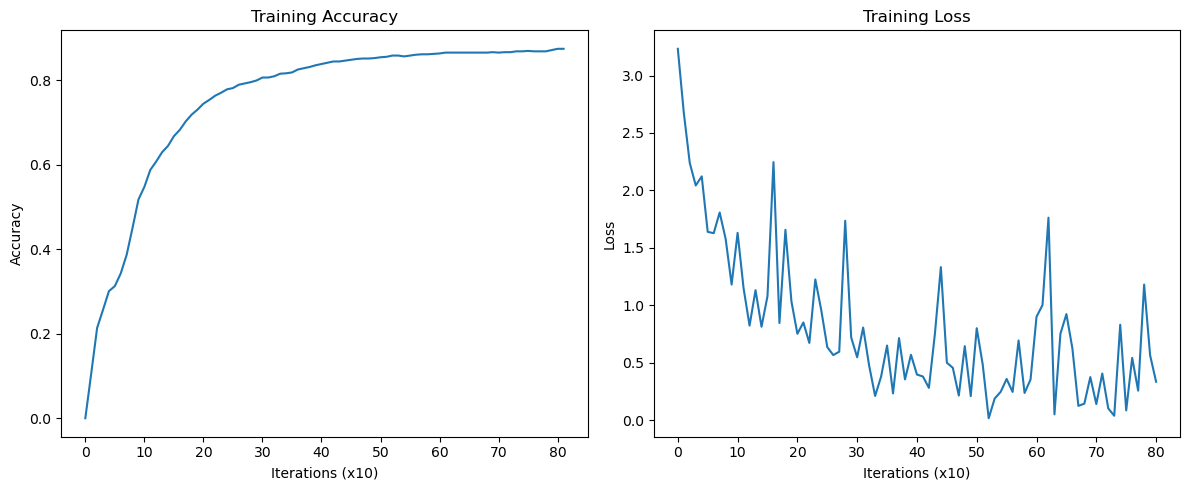

Iteration: 810
Accuracy: 0.878
Loss: 0.6957919782741743


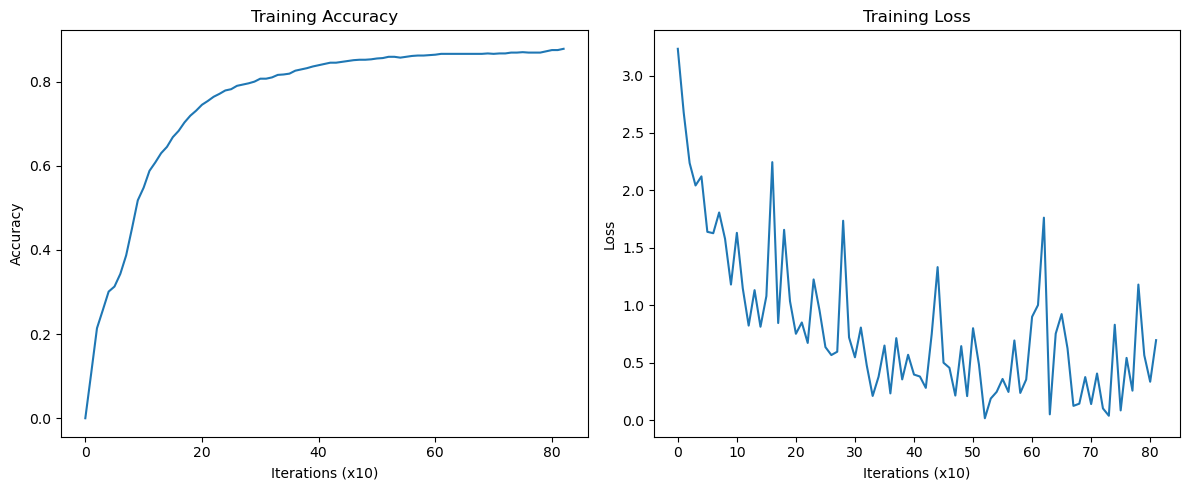

Iteration: 820
Accuracy: 0.876
Loss: 0.7381431454040509


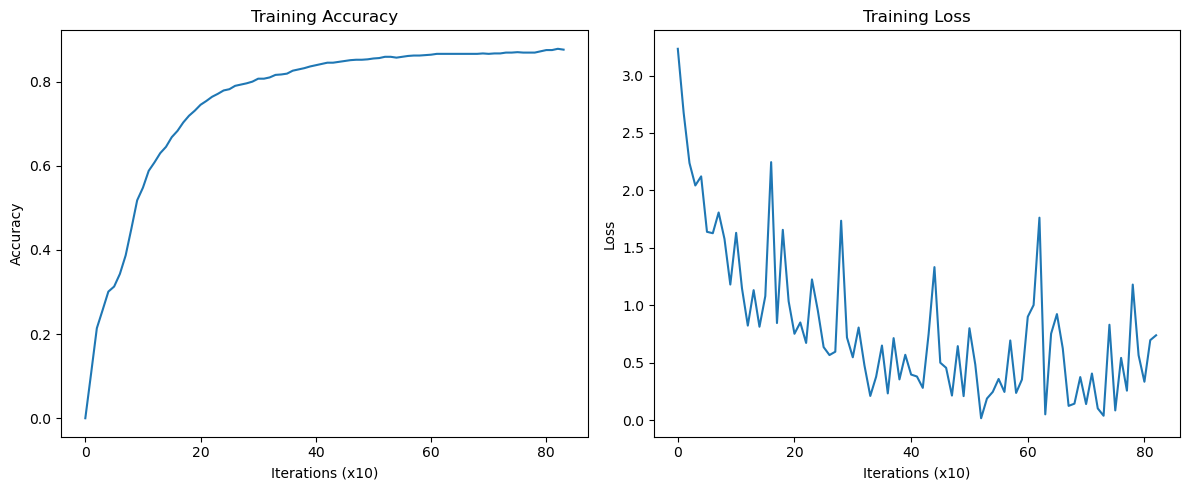

Iteration: 830
Accuracy: 0.877
Loss: 0.8246862268256429


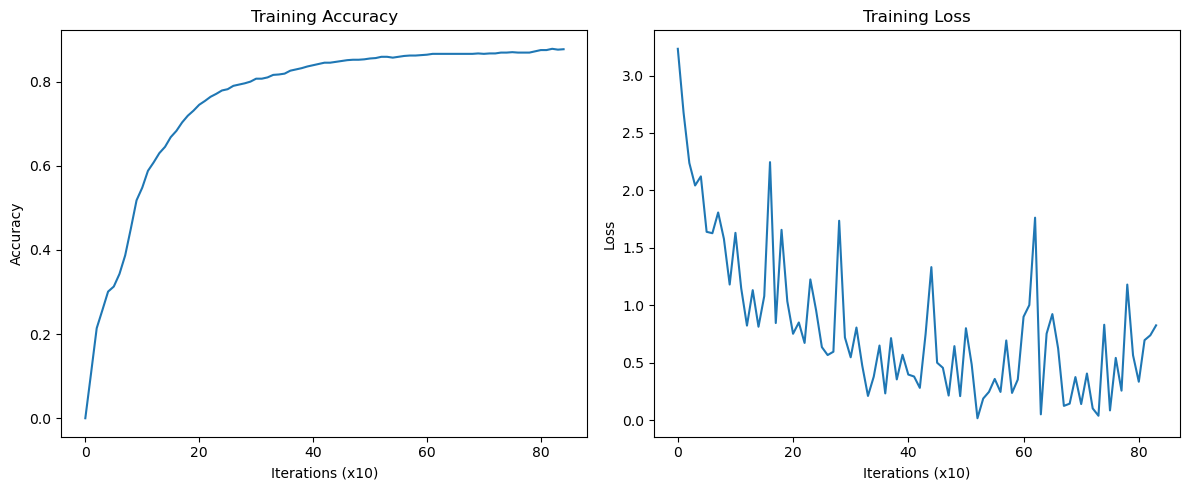

Iteration: 840
Accuracy: 0.875
Loss: 0.5391605716091218


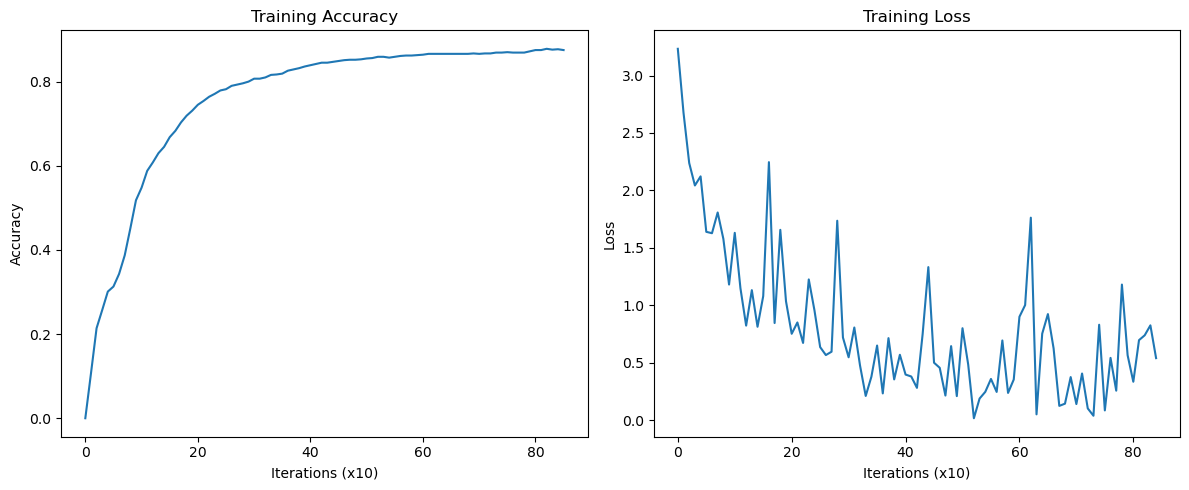

Iteration: 850
Accuracy: 0.877
Loss: 0.5340321623953175


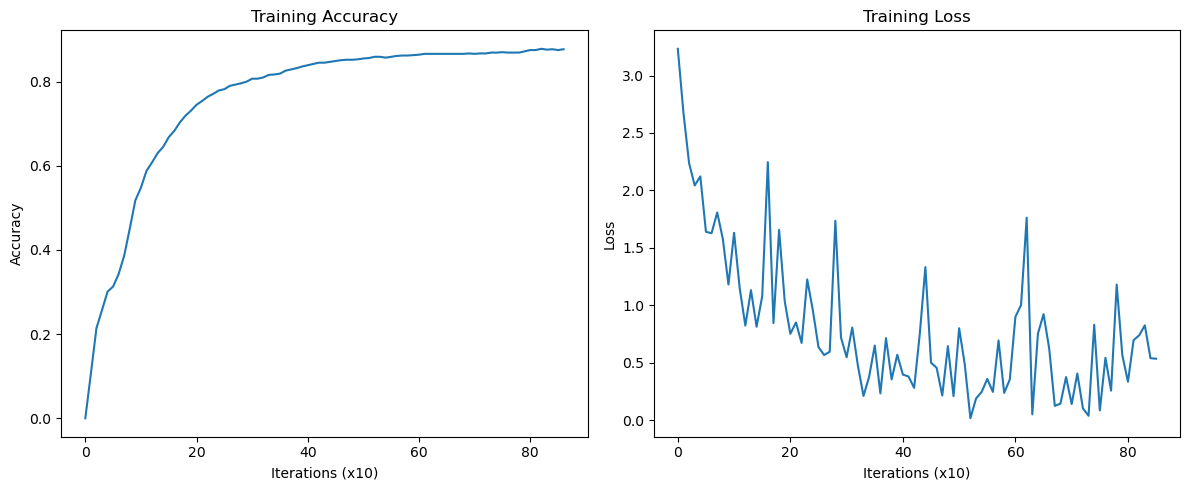

Iteration: 860
Accuracy: 0.877
Loss: 0.785771979846342


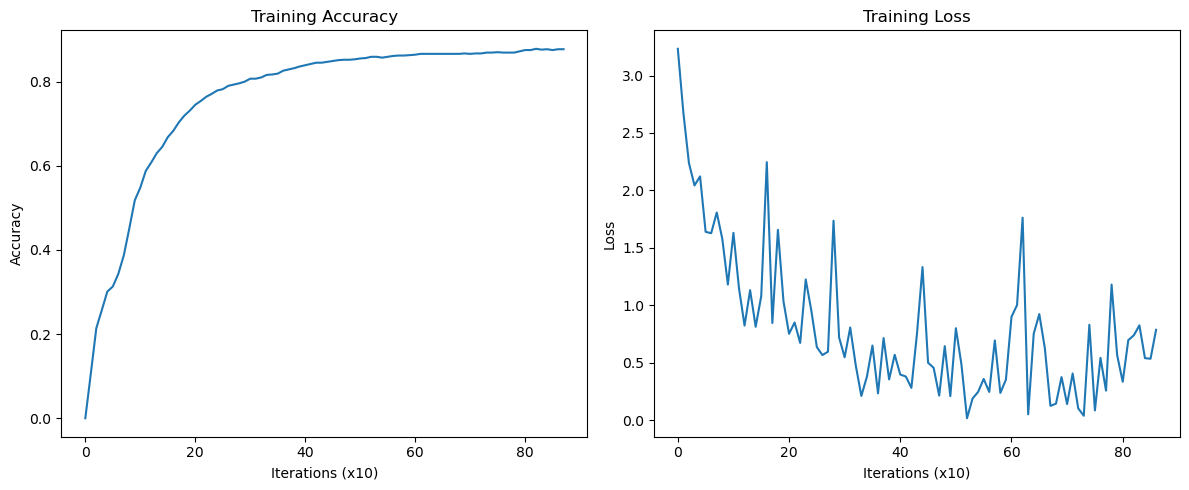

Iteration: 870
Accuracy: 0.877
Loss: 0.05882644584354873


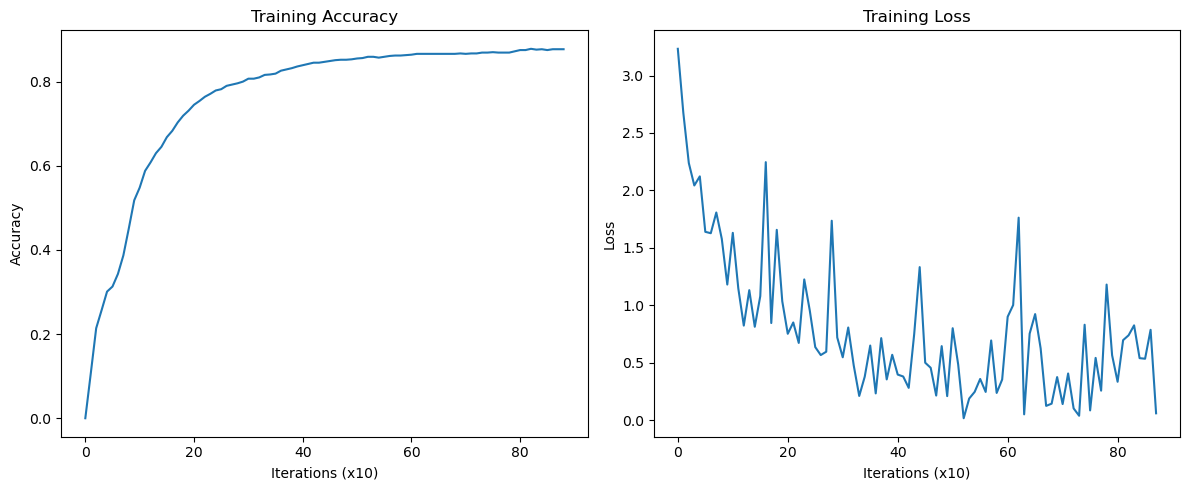

Iteration: 880
Accuracy: 0.877
Loss: 0.5972778082170586


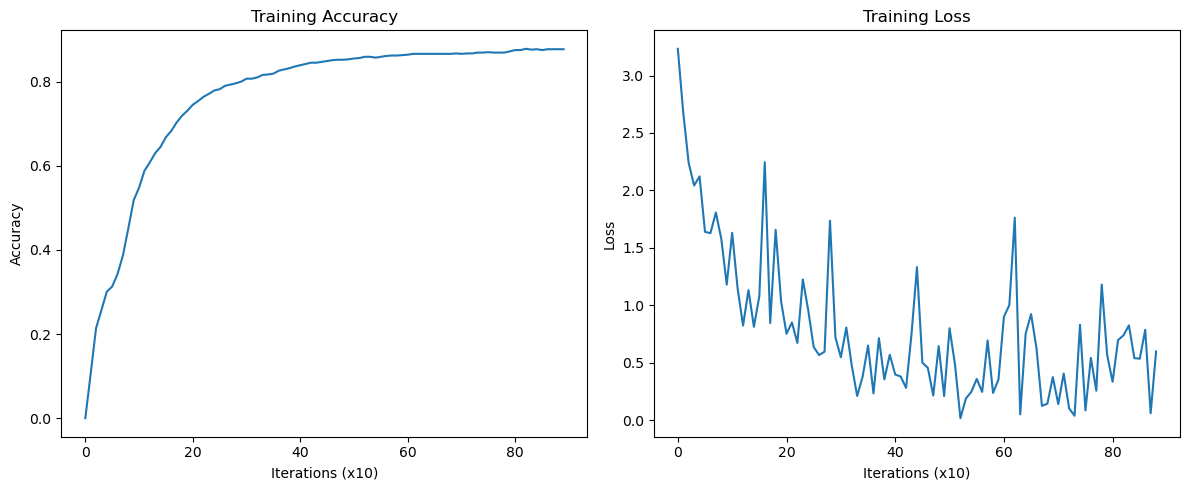

Iteration: 890
Accuracy: 0.878
Loss: 0.08360641660595111


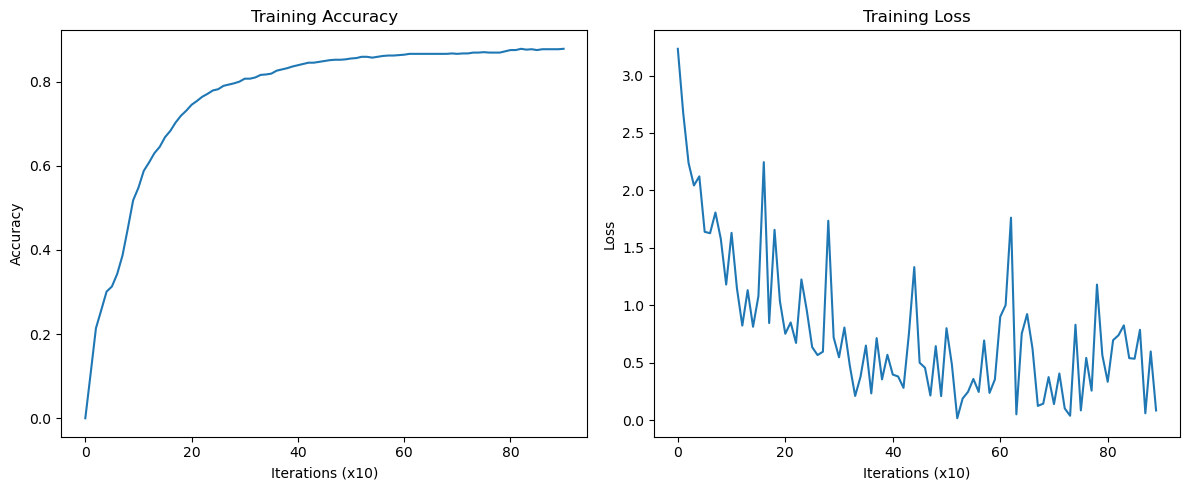

Iteration: 900
Accuracy: 0.881
Loss: 0.5353673259360555


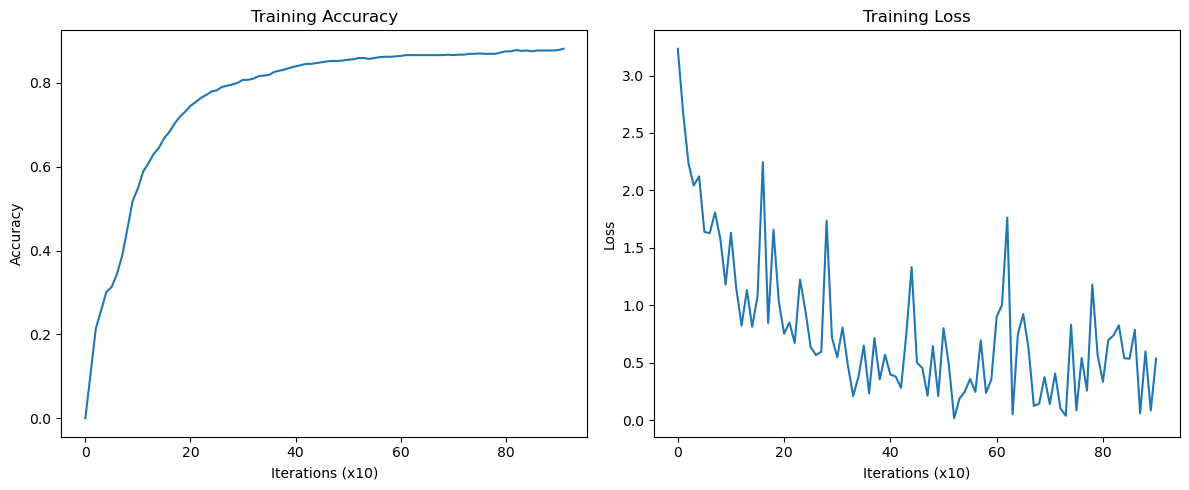

Iteration: 910
Accuracy: 0.881
Loss: 0.13604242917889736


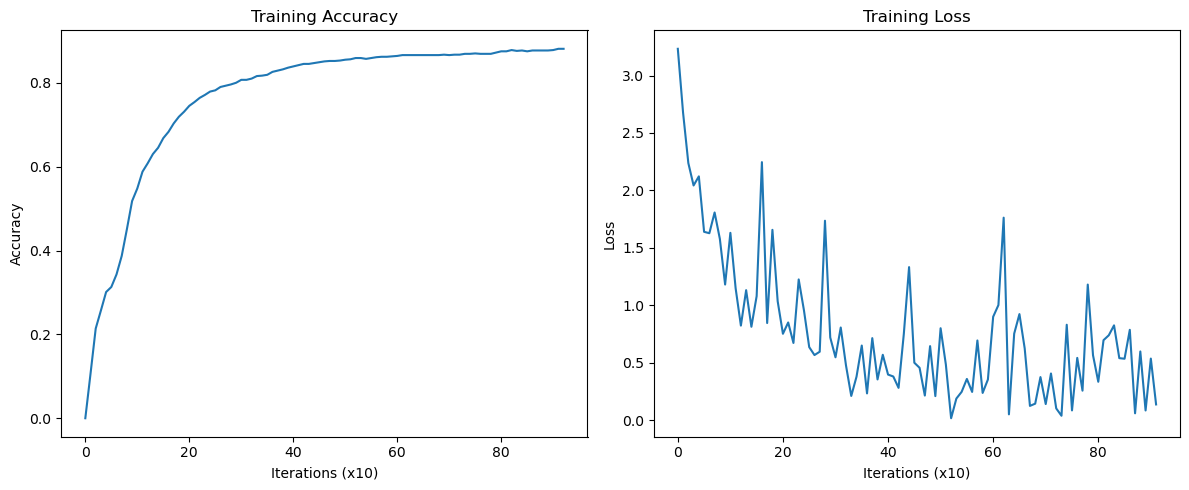

Iteration: 920
Accuracy: 0.882
Loss: 0.08752562228890015


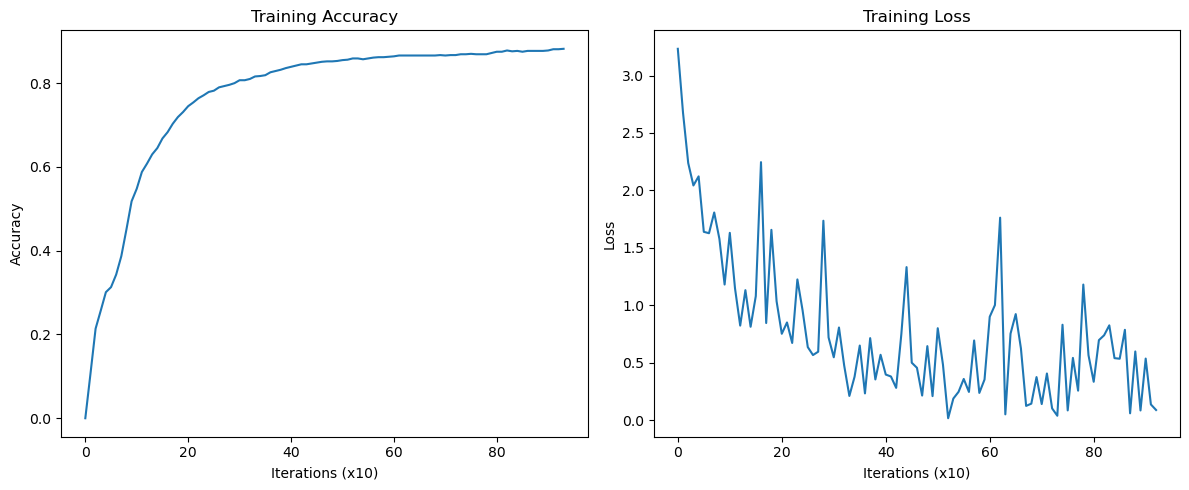

Iteration: 930
Accuracy: 0.882
Loss: 0.1374254523175476


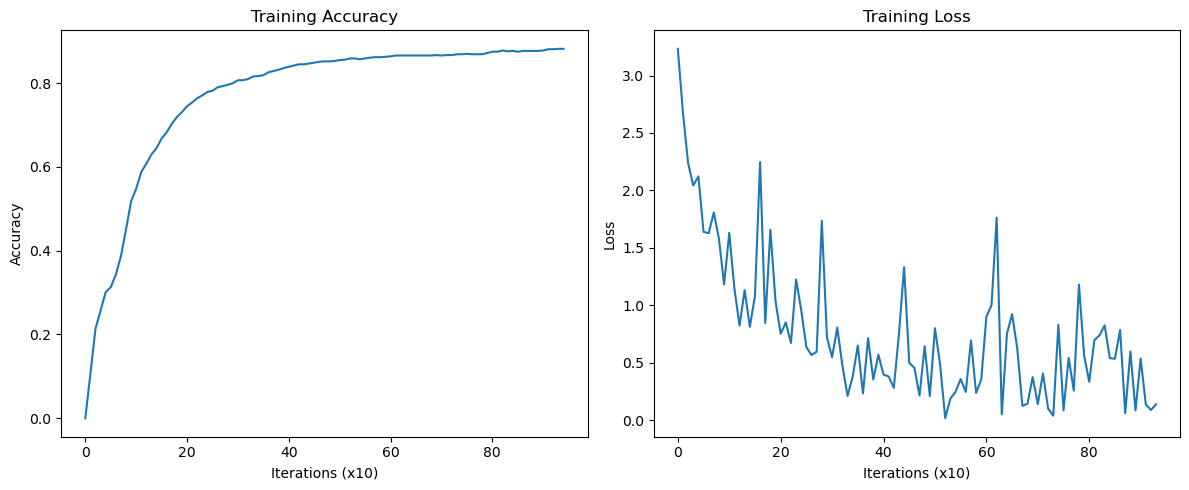

Iteration: 940
Accuracy: 0.882
Loss: 0.44135434510994026


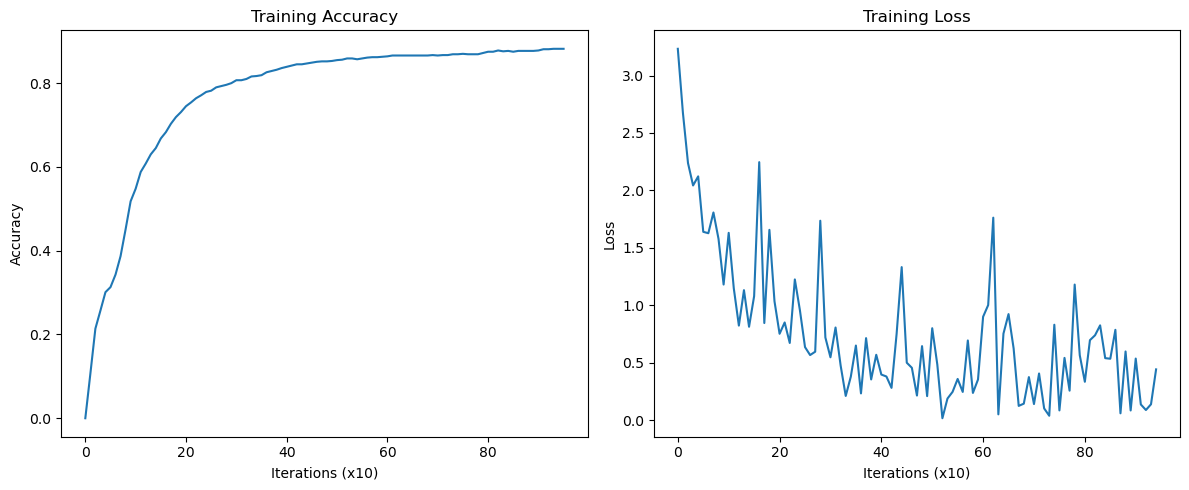

Iteration: 950
Accuracy: 0.882
Loss: 0.0560828804298449


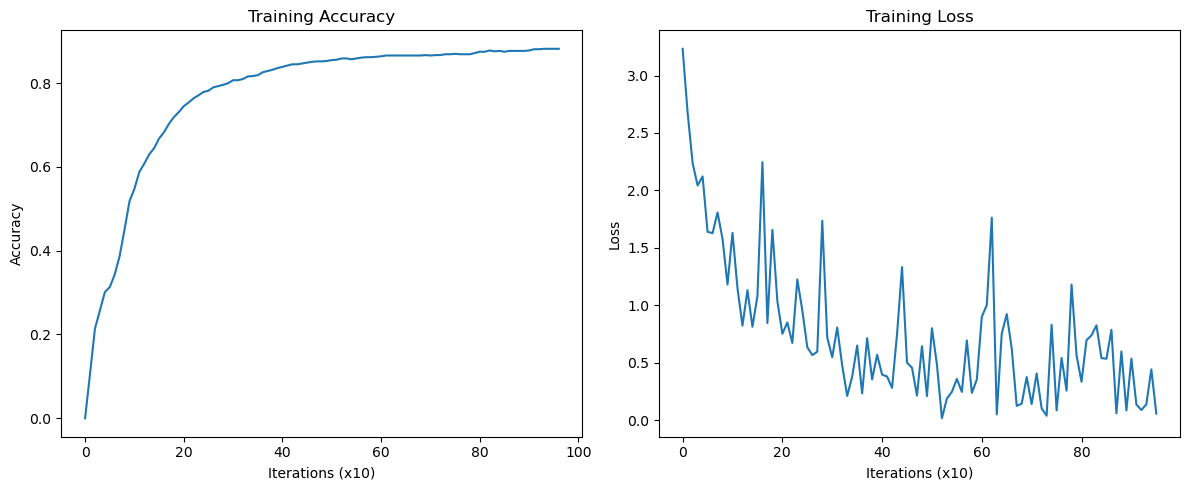

Iteration: 960
Accuracy: 0.883
Loss: 0.36383244247536917


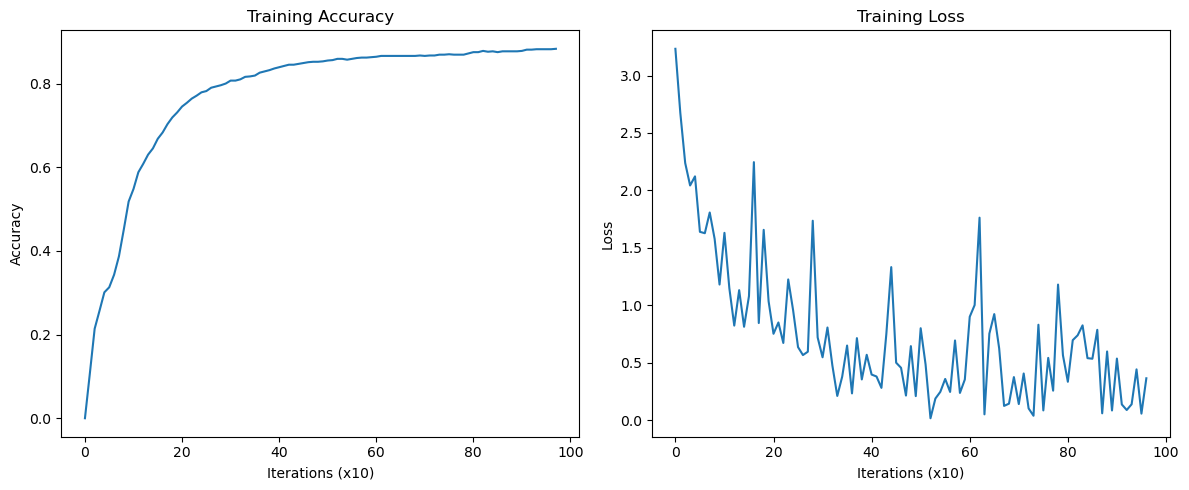

Iteration: 970
Accuracy: 0.885
Loss: 0.2753392255349219


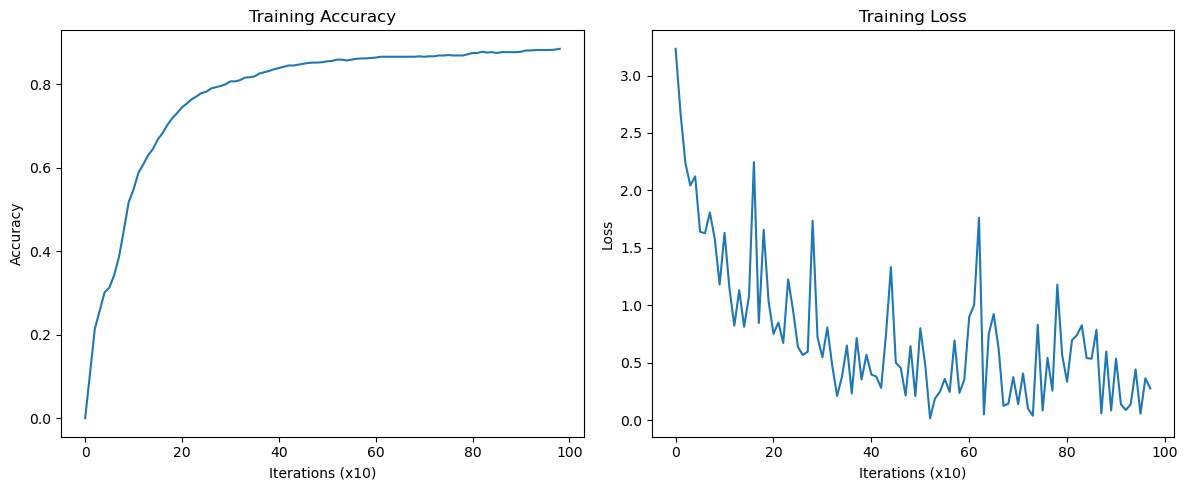

Iteration: 980
Accuracy: 0.885
Loss: 0.19103485336148612


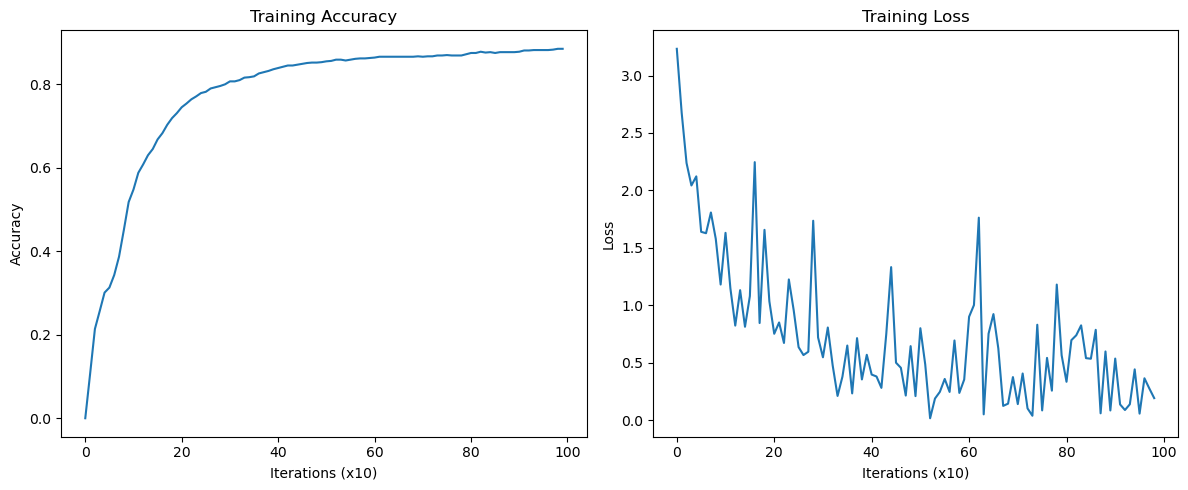

Iteration: 990
Accuracy: 0.887
Loss: 0.509152725959358


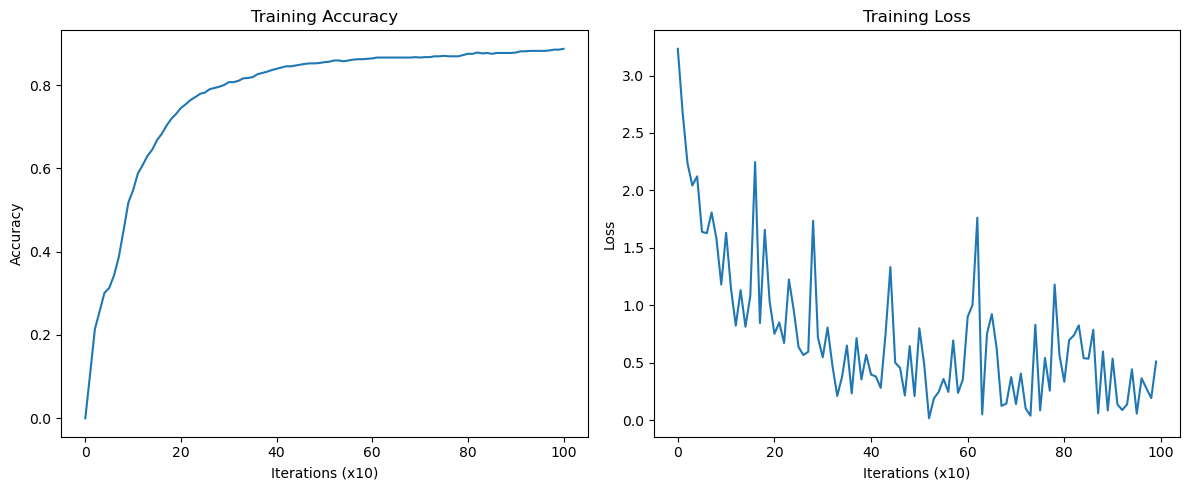

In [83]:
W1, b1, W2, b2 = mini_batch_gradient_descent(values_train, labels_train, ITERATIONS, ALPHA, BATCHSIZE, values_validation, labels_validation)

In [84]:
def evaluate_model(W1, b1, W2, b2, values, labels):
    _, _, _, A2 = forward_propagation(W1, b1, W2, b2, values)
    predictions = get_predictions(A2)
    accuracy = get_accuracy(predictions, labels)
    loss = cross_entropy_loss(A2, one_hot(labels))

    return accuracy, loss

print(evaluate_model(W1, b1, W2, b2, values_test, labels_test))

(0.886, 0.36385594412058864)
